In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
import h5py
import matplotlib.pyplot as plt

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=180,  frameon=False, figsize=(5, 5))

scanpy==1.4.5 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.4 scipy==1.4.1 pandas==0.25.3 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1+4.bed07760 louvain==0.6.1


In [3]:
results_file = '../output/bleo.h5ad'

In [4]:
adata_wt = sc.read_10x_mtx(
    '../output/RNA_corrected_counts/wtcounts/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster subsequent reading

... reading from cache file cache\..-output-RNA_corrected_counts-wtcounts-matrix.h5ad


In [5]:
adata_single = sc.read_10x_mtx(
    '../output/RNA_corrected_counts/singledosecounts/', 
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... reading from cache file cache\..-output-RNA_corrected_counts-singledosecounts-matrix.h5ad


In [6]:
adata_rep = sc.read_10x_mtx(
    '../output/RNA_corrected_counts/repdosecounts/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... reading from cache file cache\..-output-RNA_corrected_counts-repdosecounts-matrix.h5ad


In [7]:
adata = adata_wt.concatenate(adata_single, adata_rep, batch_categories = ['WT','Singledose','Repdose'])


In [8]:
print(adata_wt)
print(adata_single)
print(adata_rep)
print(adata)

AnnData object with n_obs × n_vars = 5305 × 27998 
    var: 'gene_ids'
AnnData object with n_obs × n_vars = 9398 × 27998 
    var: 'gene_ids'
AnnData object with n_obs × n_vars = 3134 × 27998 
    var: 'gene_ids'
AnnData object with n_obs × n_vars = 17837 × 27998 
    obs: 'batch'
    var: 'gene_ids'


In [9]:
#sc.pp.combat(adata)

In [10]:
adata.var_names_make_unique()

In [11]:
print(adata)
print(adata.obs)
print(adata.var.T)

AnnData object with n_obs × n_vars = 17837 × 27998 
    obs: 'batch'
    var: 'gene_ids'
                            batch
AAACCTGCATGTCGAT-WT            WT
AAACCTGTCACCTCGT-WT            WT
AAACCTGTCCACGCAG-WT            WT
AAACCTGTCCAGAAGG-WT            WT
AAACCTGTCCCAAGTA-WT            WT
...                           ...
TTTGTCACACAGGAGT-Repdose  Repdose
TTTGTCACACCATCCT-Repdose  Repdose
TTTGTCACATCGGGTC-Repdose  Repdose
TTTGTCACATGGATGG-Repdose  Repdose
TTTGTCATCTGGTTCC-Repdose  Repdose

[17837 rows x 1 columns]
          Xkr4  Gm1992  Gm37381  Rp1  Rp1.1  Sox17  Gm37323  Mrpl15  Lypla1  \
gene_ids  Xkr4  Gm1992  Gm37381  Rp1  Rp1.1  Sox17  Gm37323  Mrpl15  Lypla1   

          Gm37988  ...  AC125149.1  AC125149.2  AC125149.4  AC234645.1  \
gene_ids  Gm37988  ...  AC125149.1  AC125149.2  AC125149.4  AC234645.1   

          AC168977.2  AC168977.1  PISD  DHRSX  Vmn2r122  CAAA01147332.1  
gene_ids  AC168977.2  AC168977.1  PISD  DHRSX  Vmn2r122  CAAA01147332.1  

[1 rows x 27998 colu

normalizing counts per cell
    finished (0:00:00)


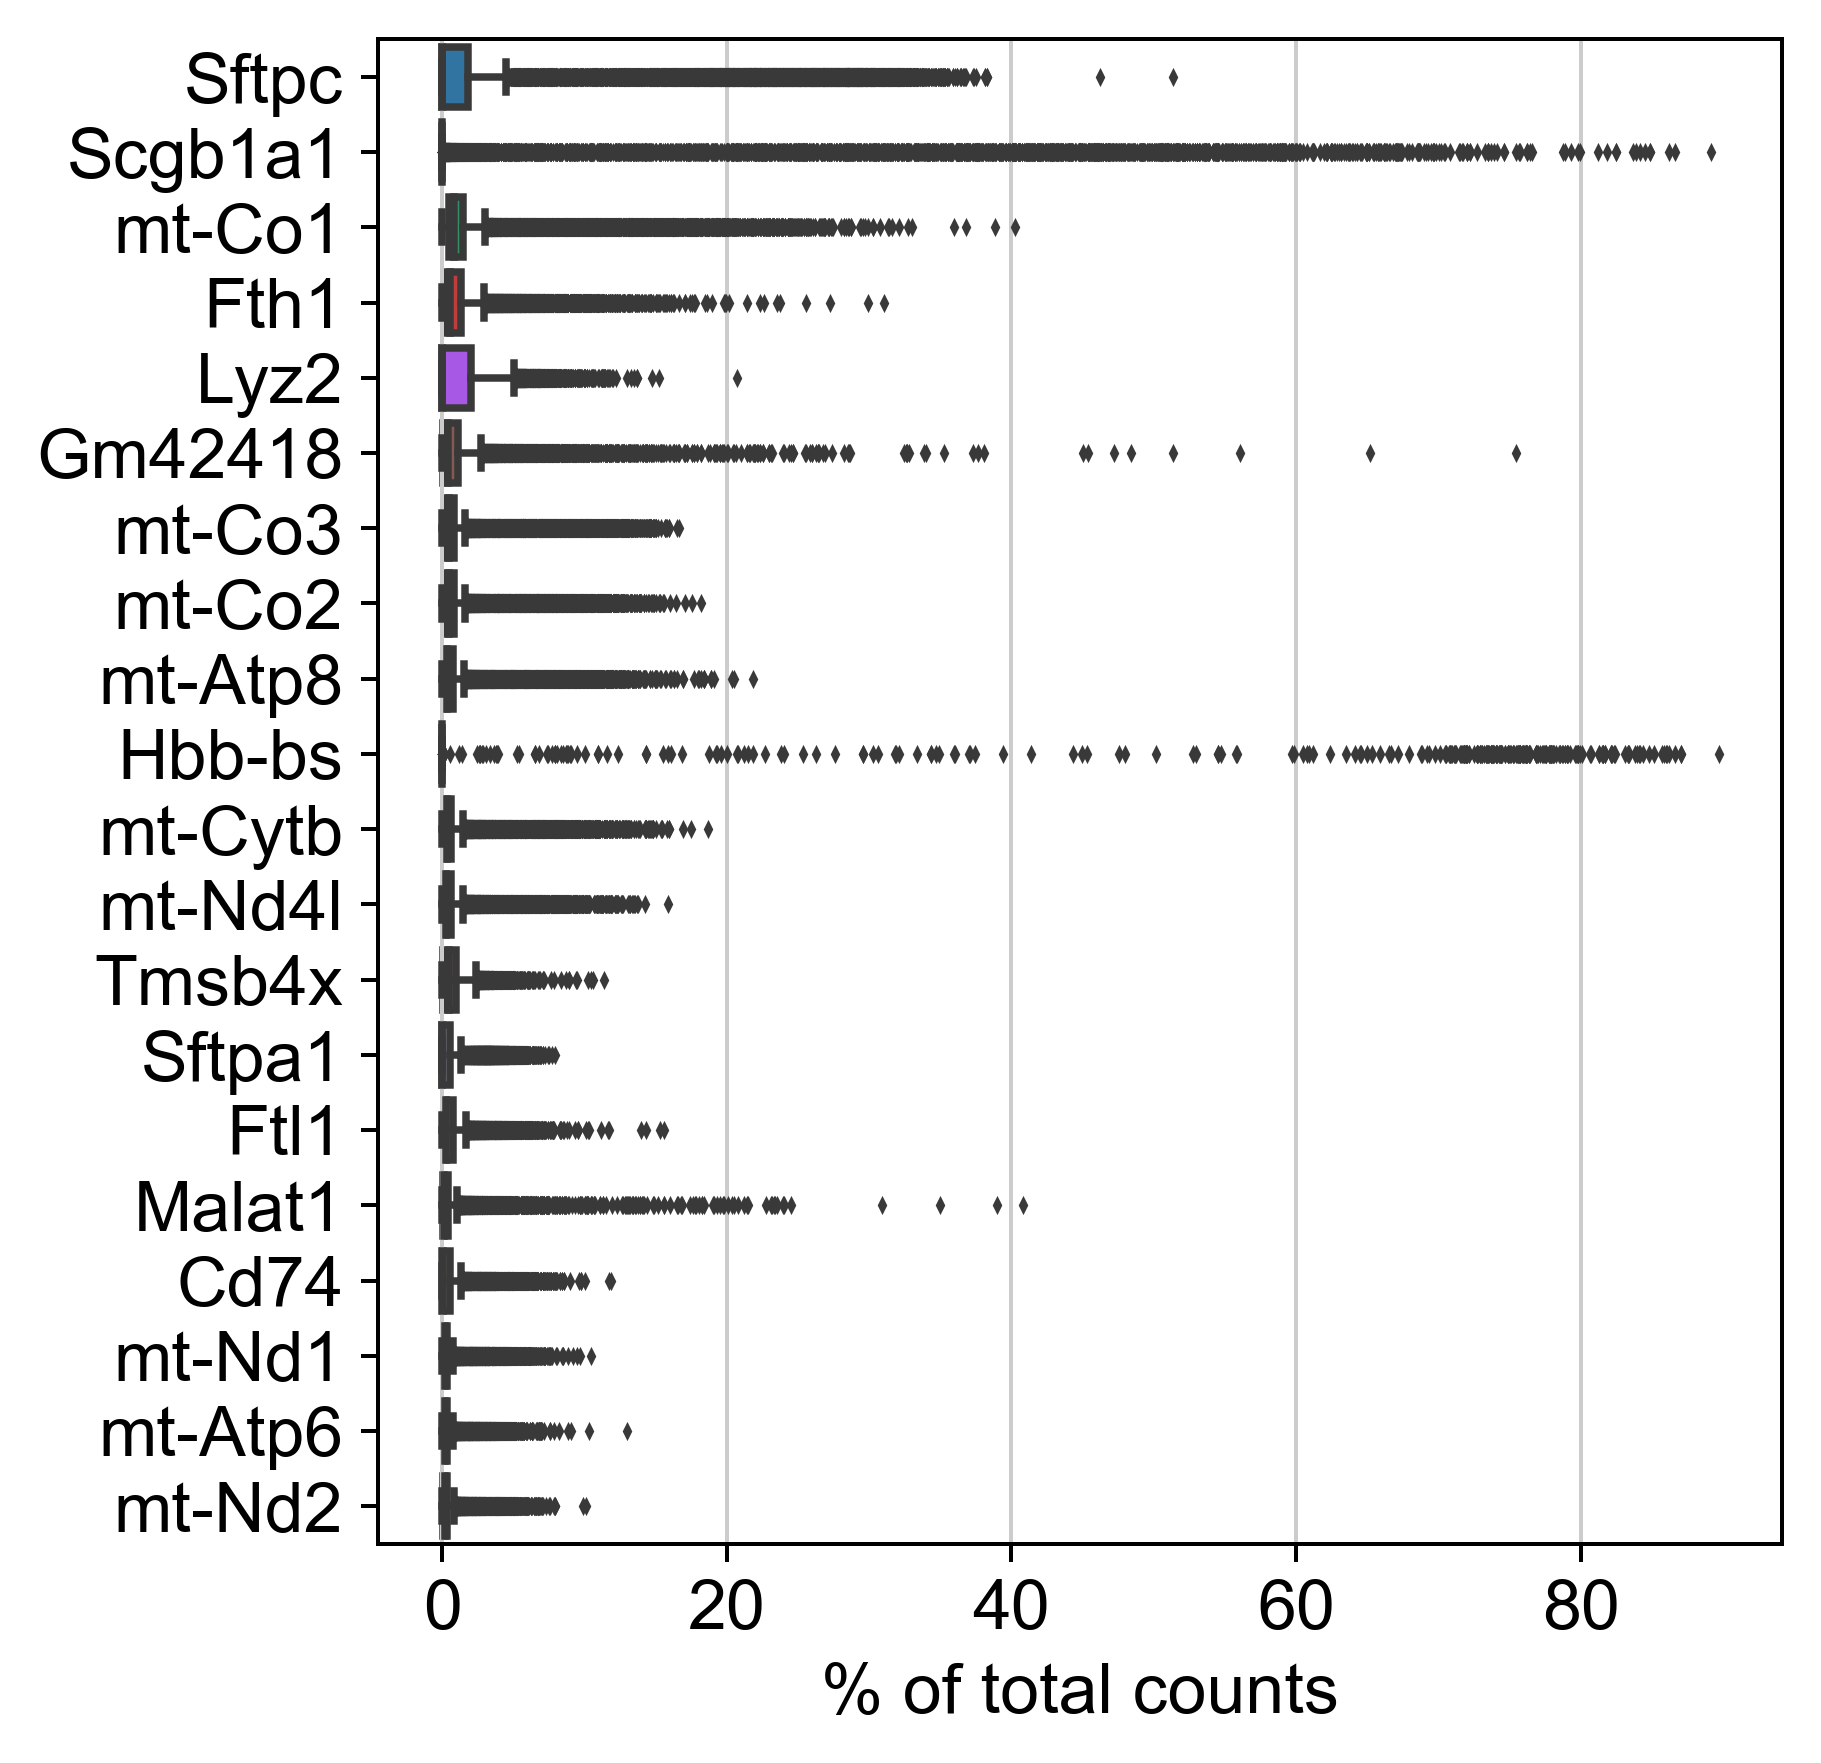

In [12]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [13]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)


filtered out 648 cells that have less than 200 genes expressed
filtered out 8013 genes that are detected in less than 3 cells


In [14]:
#sc.pp.calculate_qc_metrics(adata)

In [15]:
mito_genes = adata.var_names.str.startswith('mt-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

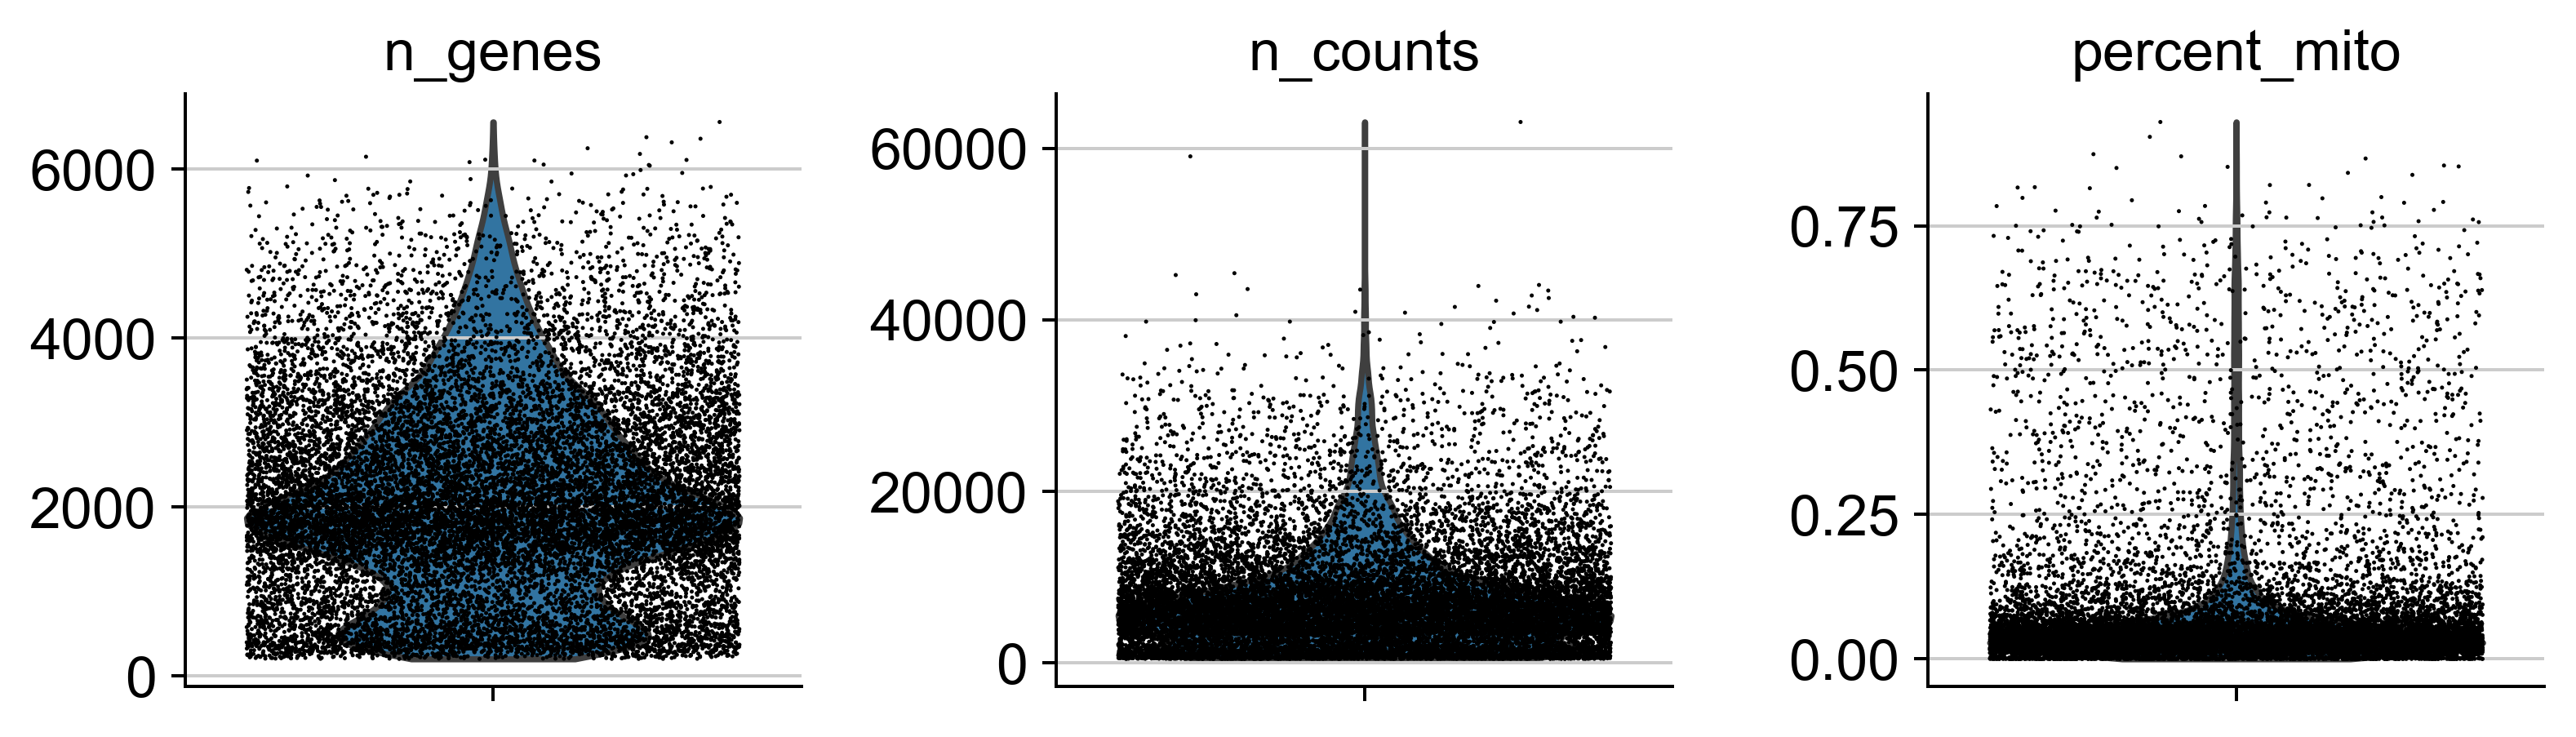

In [16]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

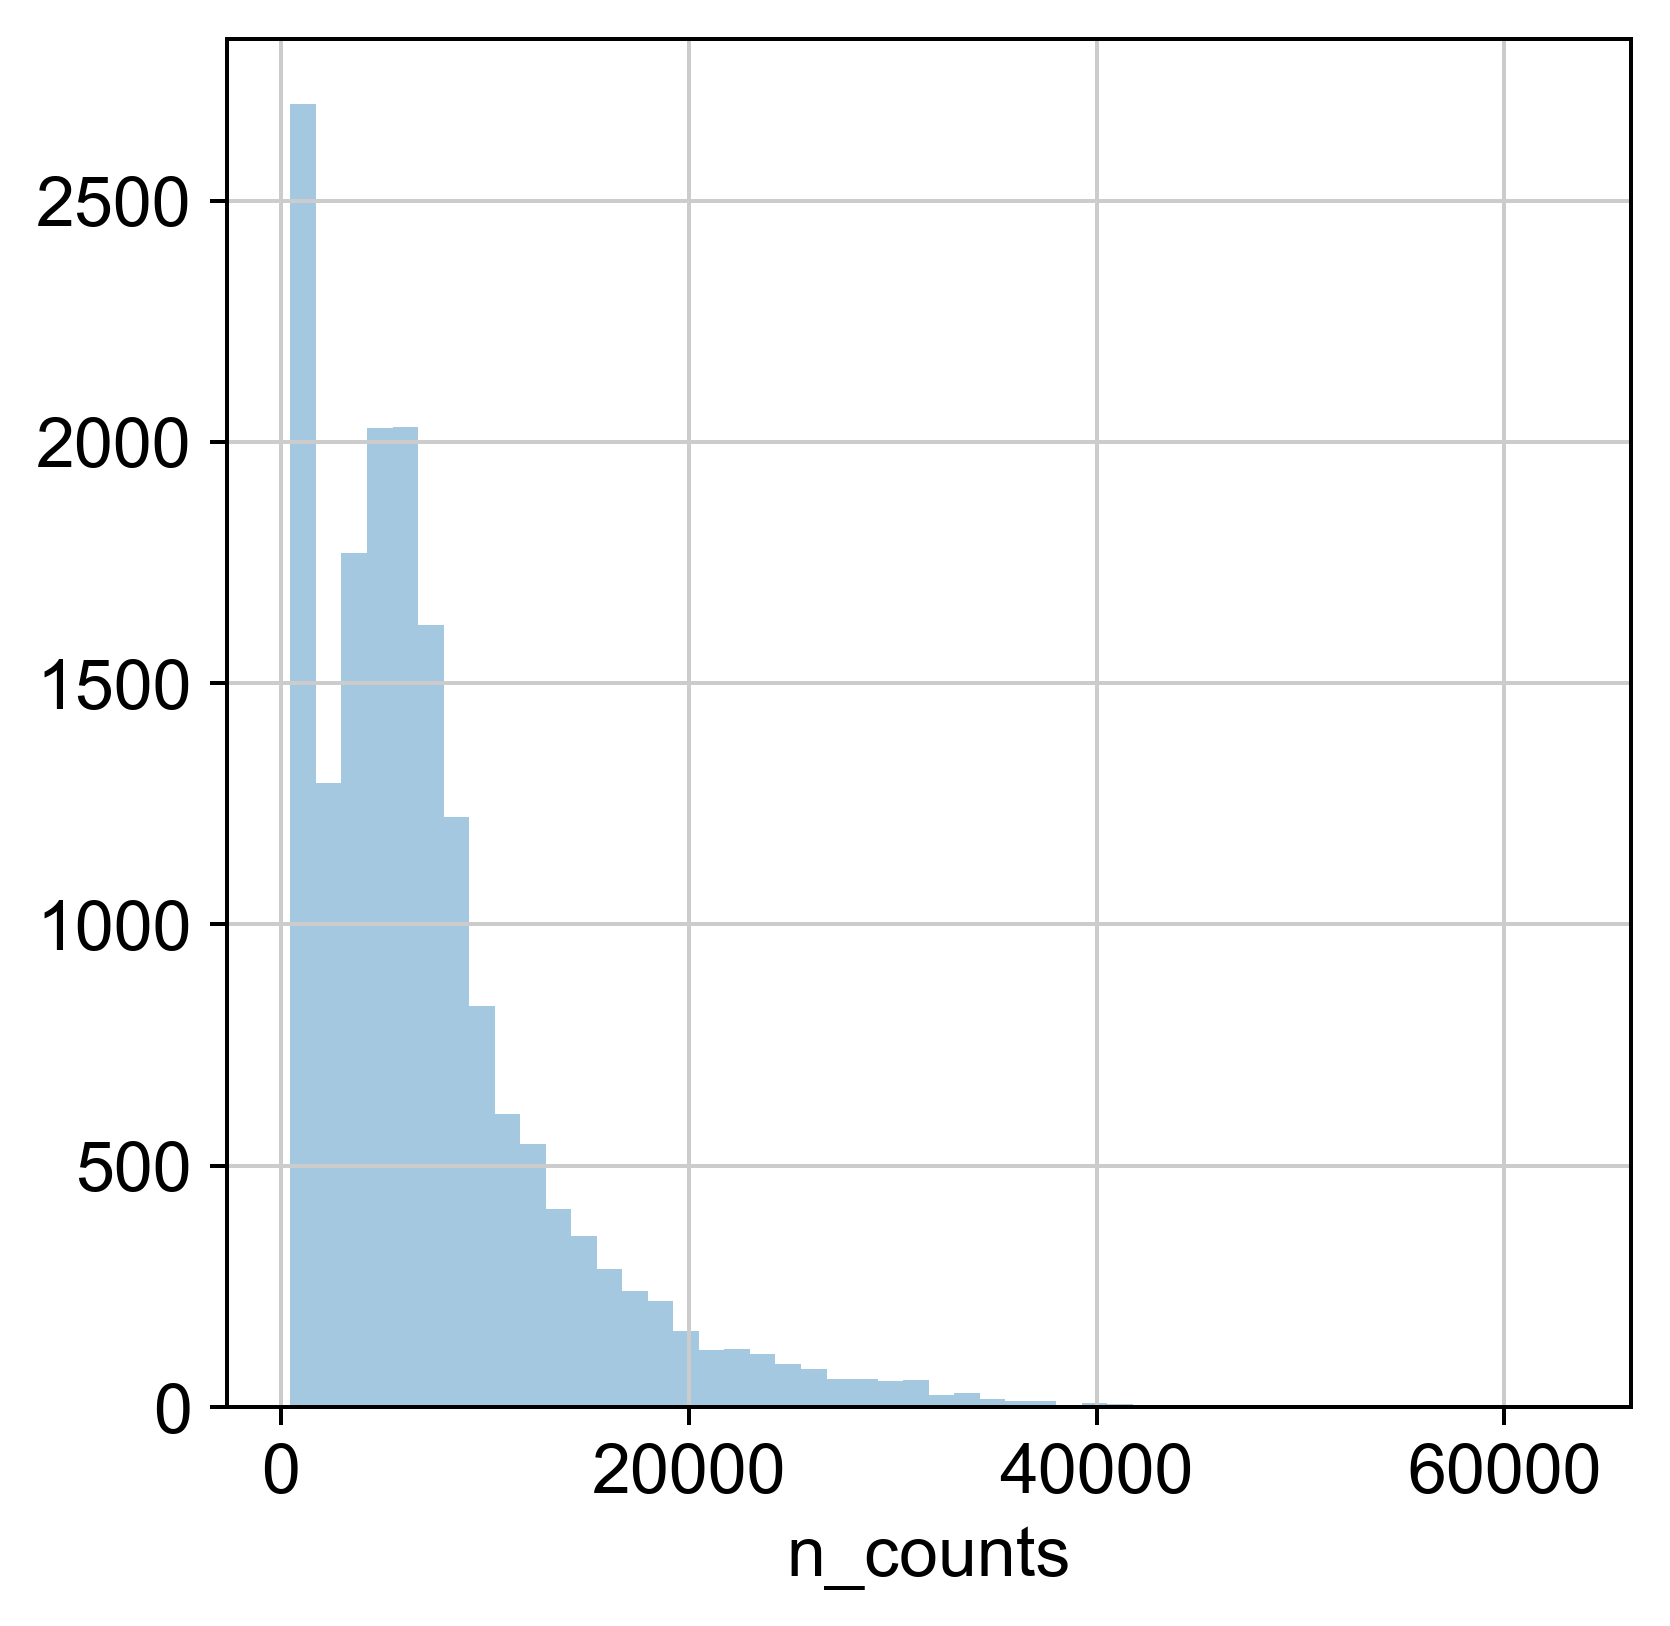

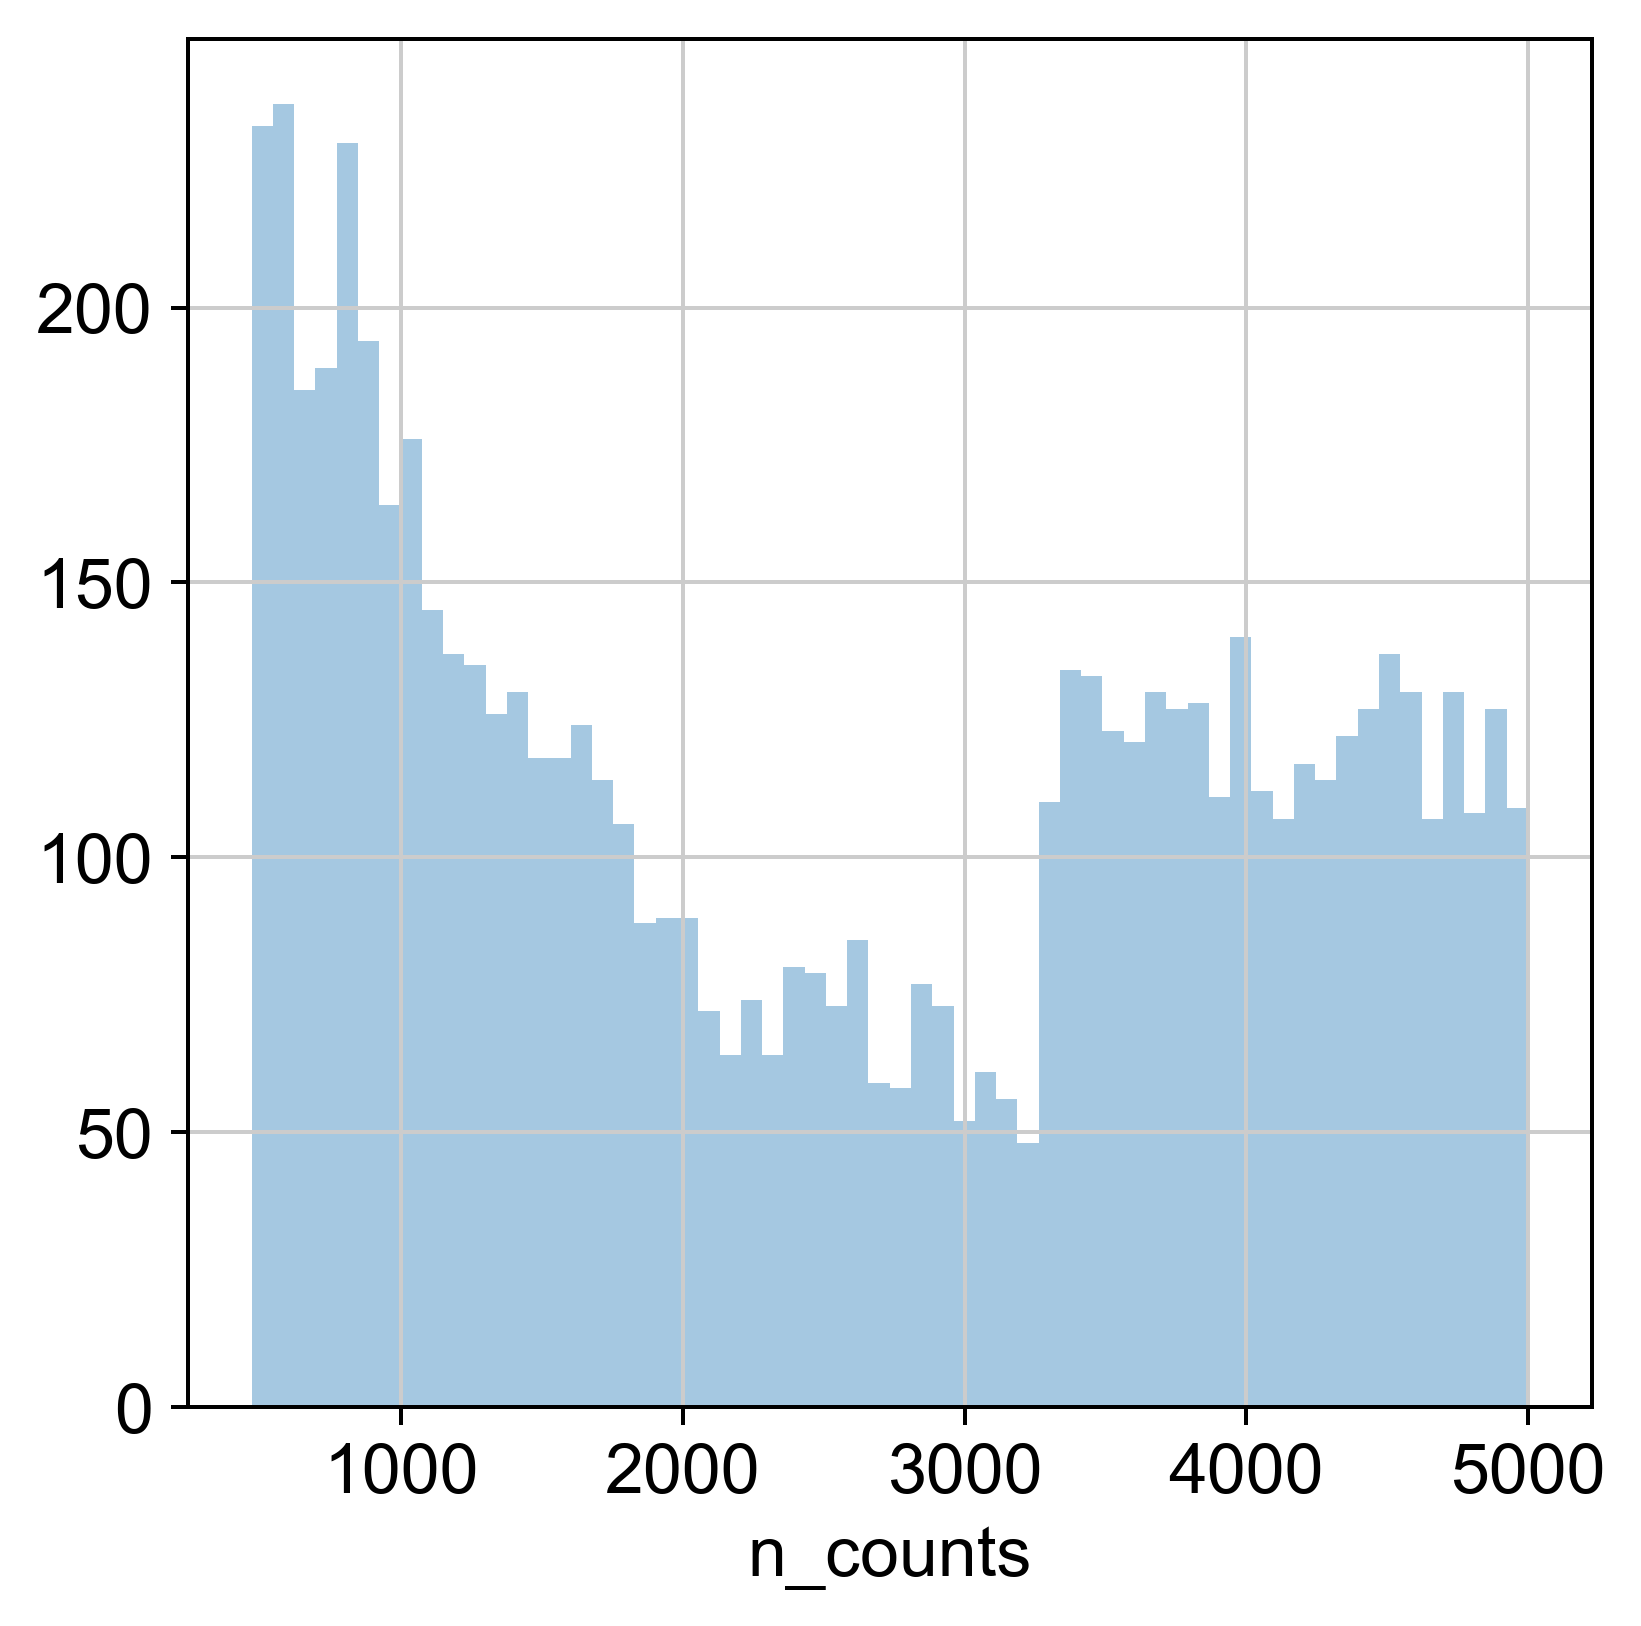

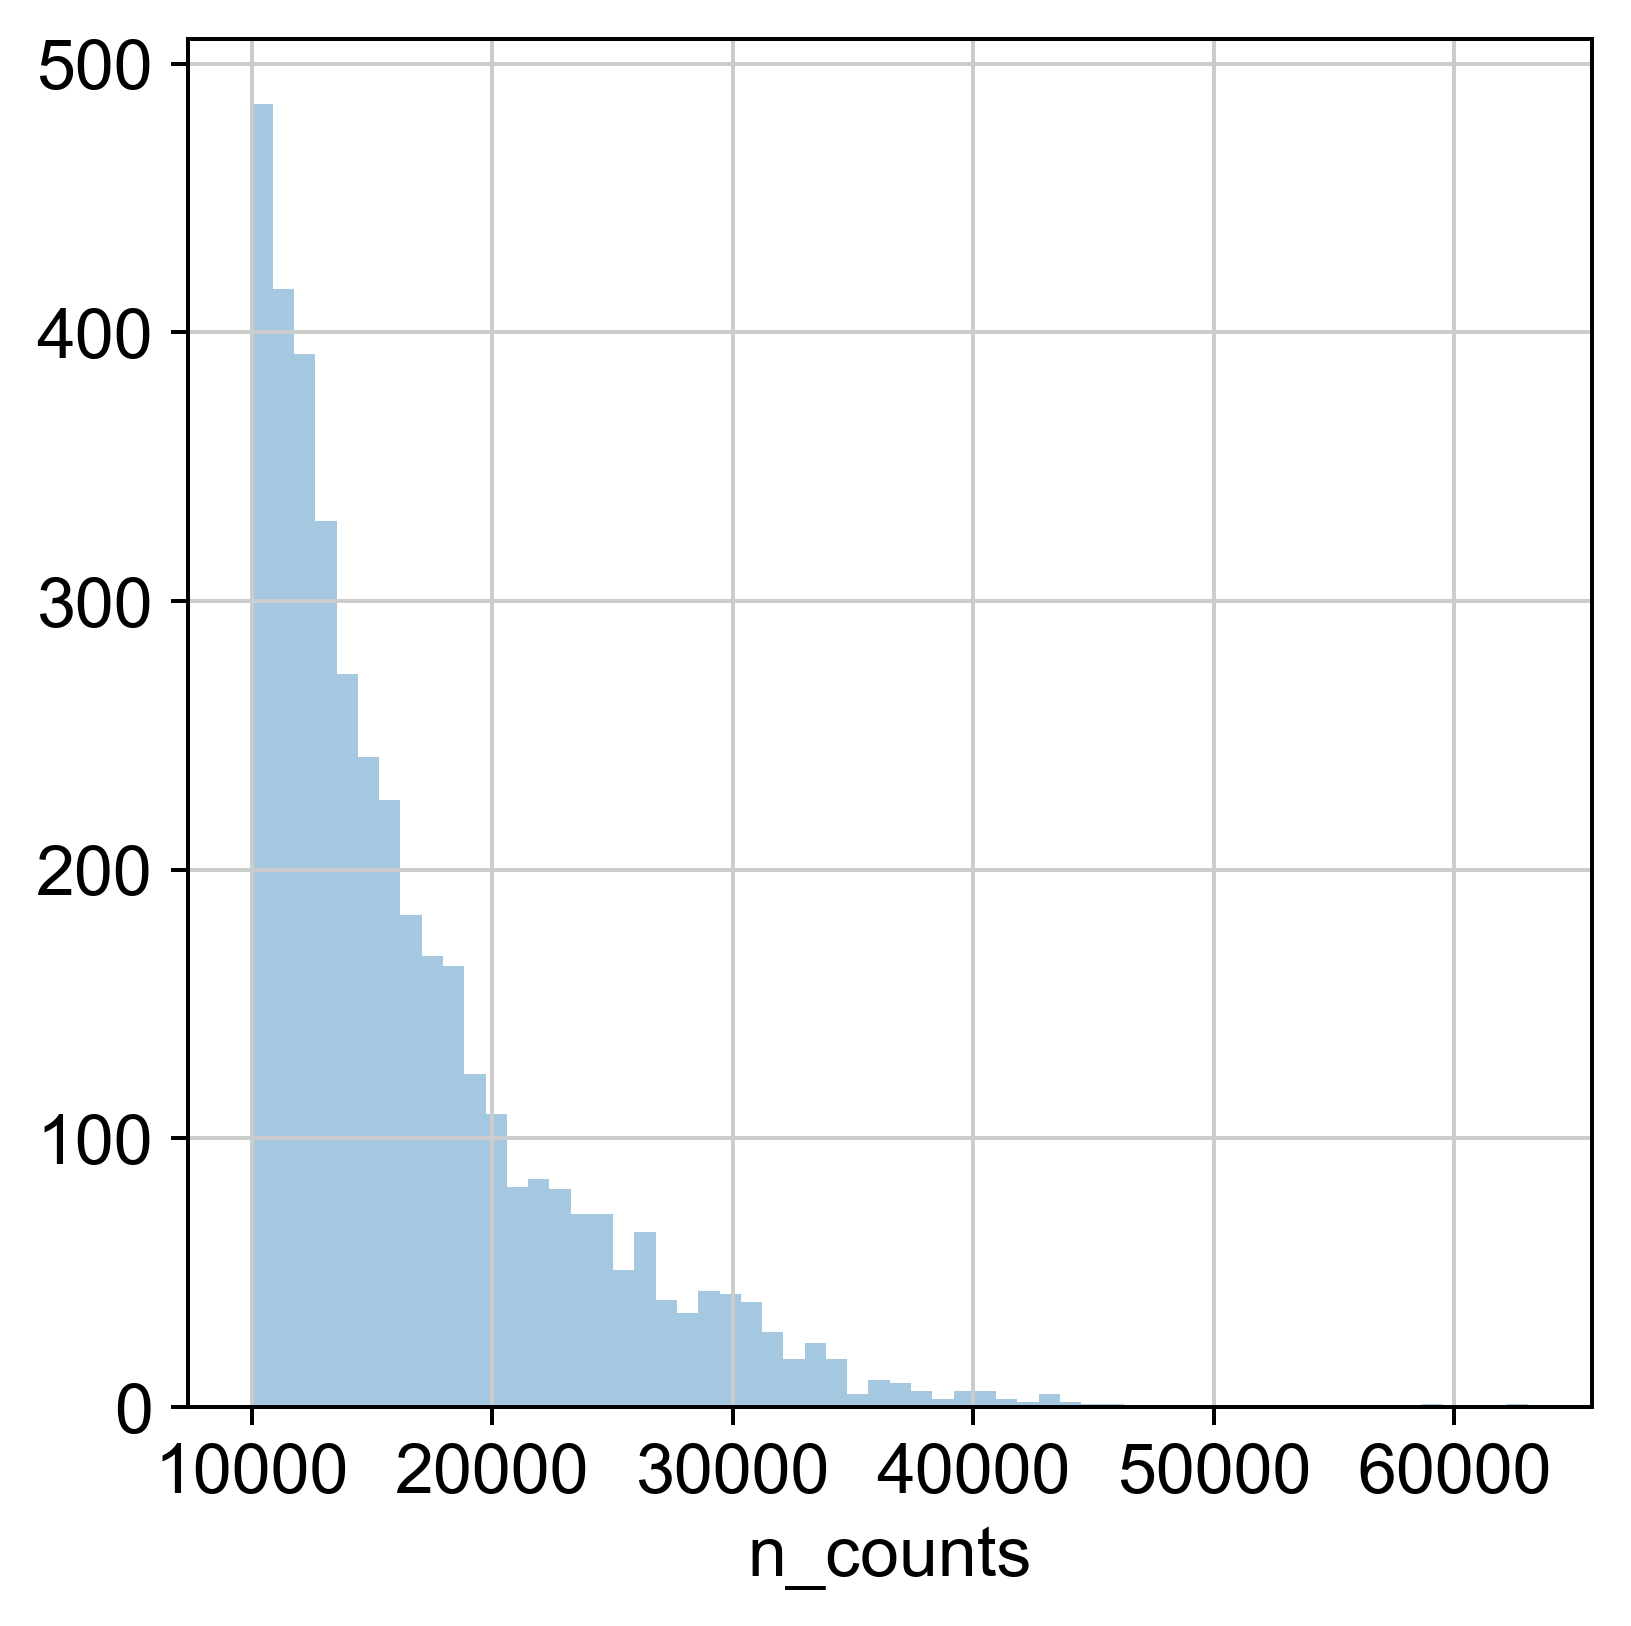

In [17]:
#Thresholding decision: counts
p3 = sns.distplot(adata.obs['n_counts'], kde=False)
plt.show()

p4 = sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']<5000], kde=False, bins=60)
plt.show()

p5 = sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], kde=False, bins=60)
plt.show()

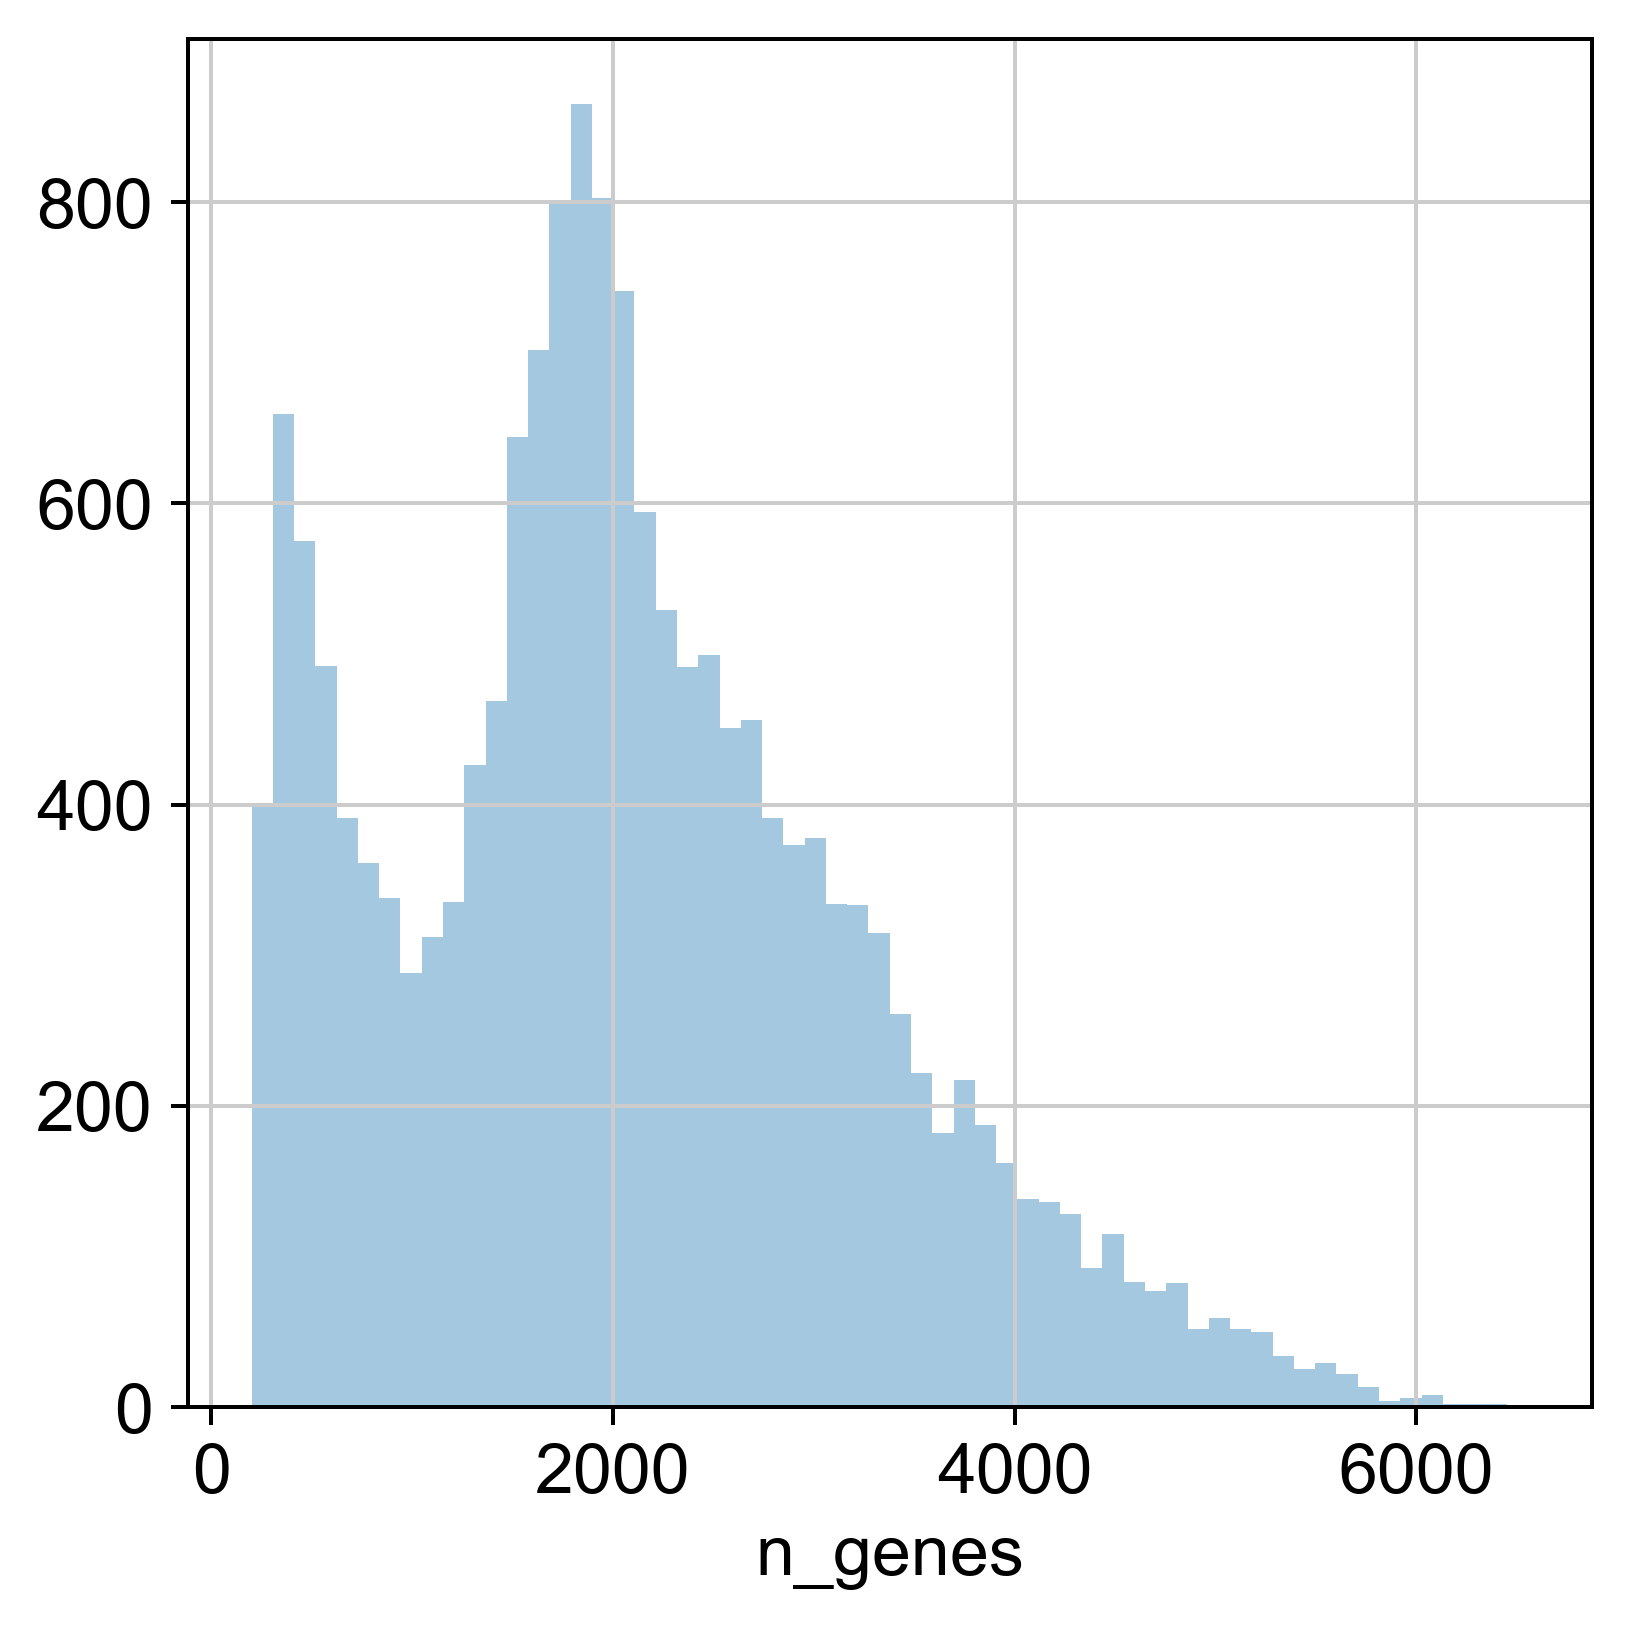

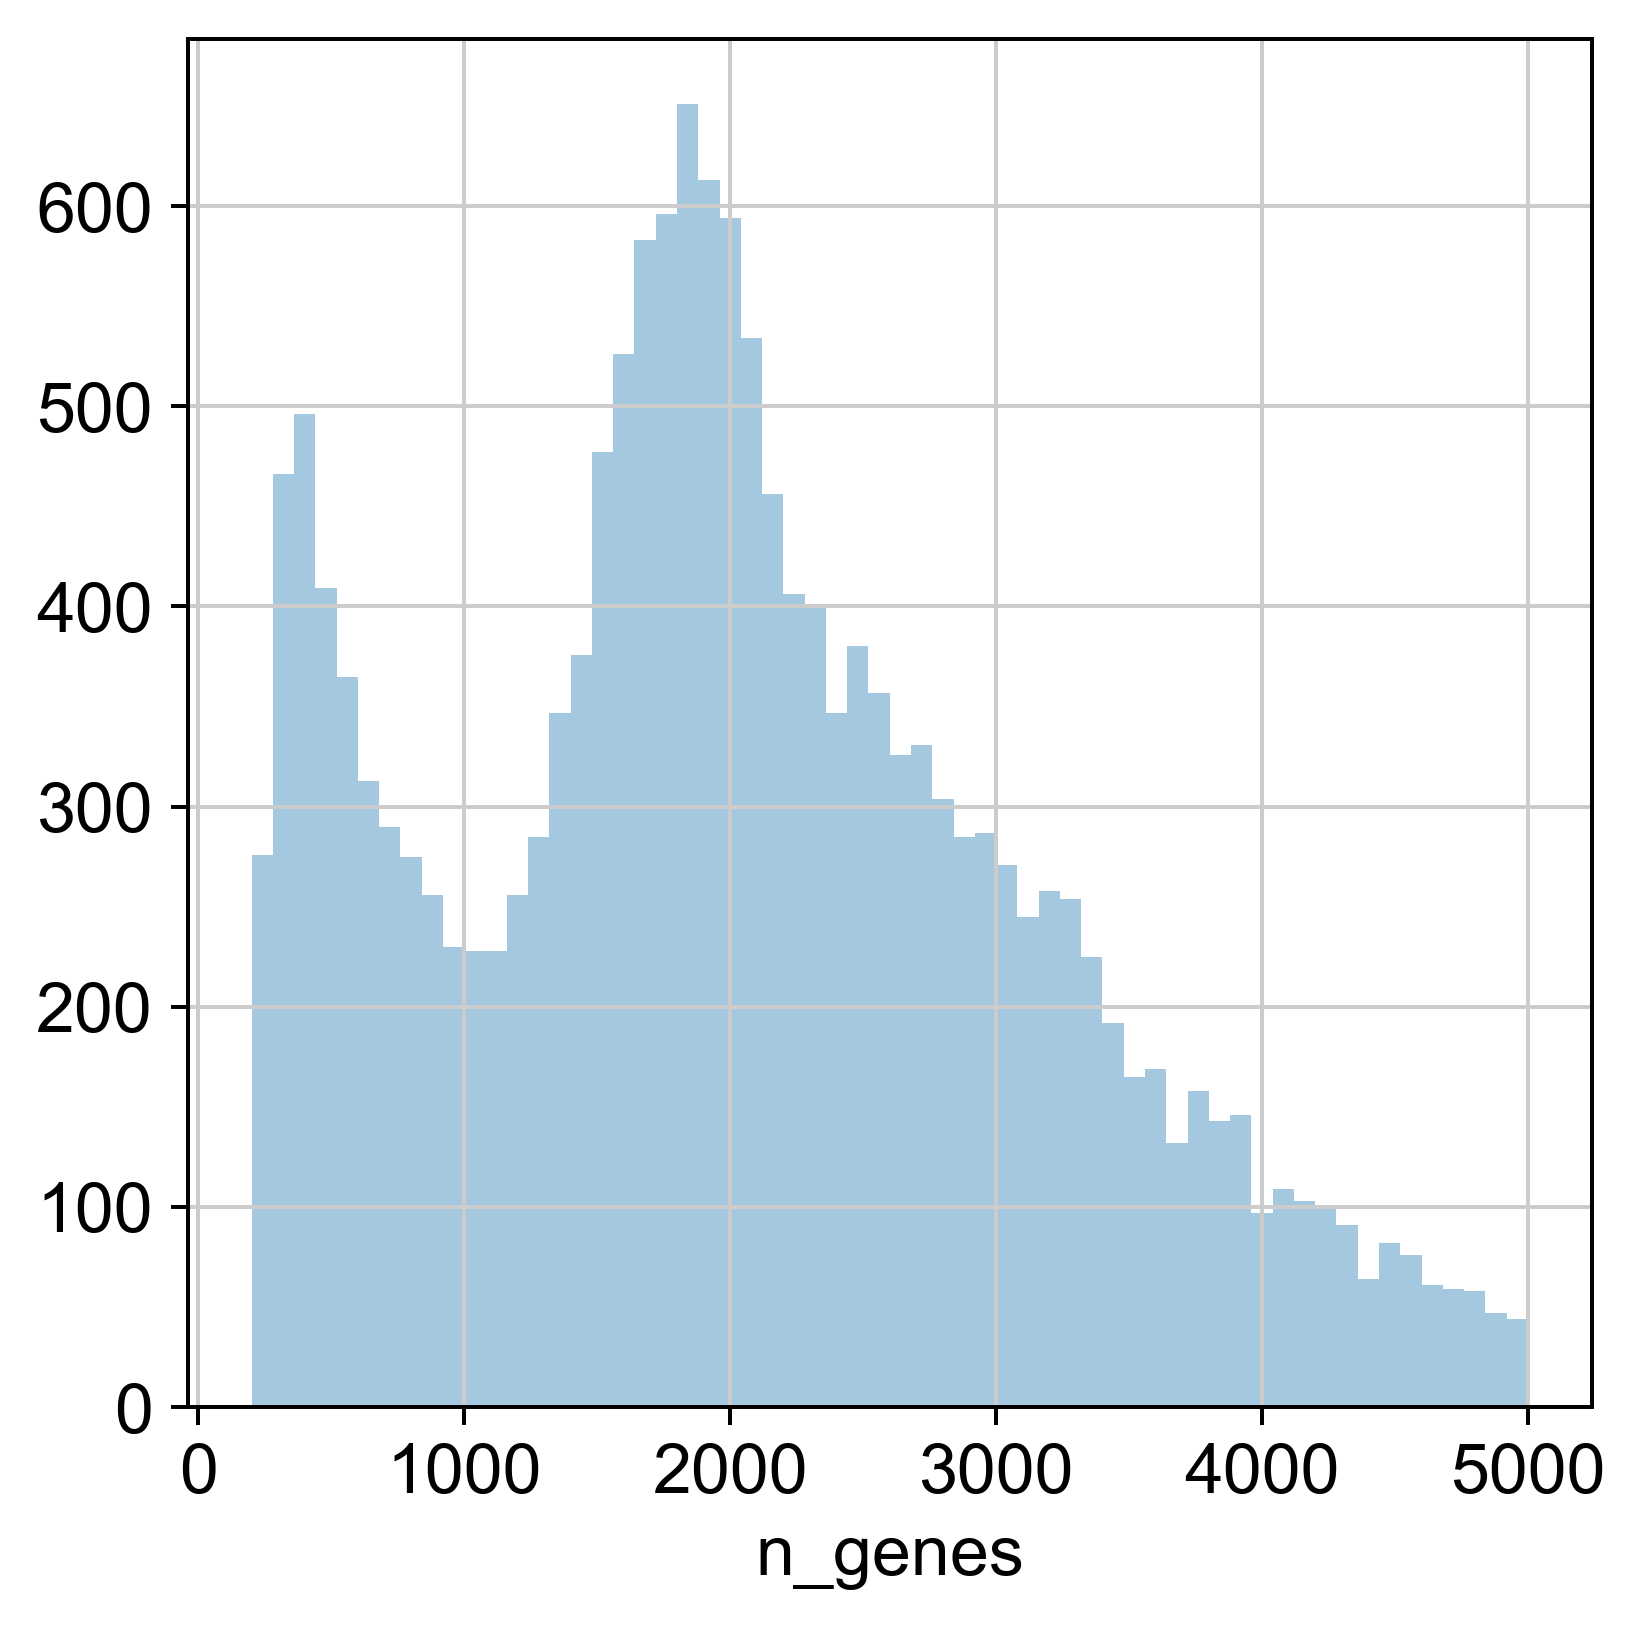

In [18]:
#Thresholding decision: genes
p6 = sns.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sns.distplot(adata.obs['n_genes'][adata.obs['n_genes']<5000], kde=False, bins=60)
plt.show()

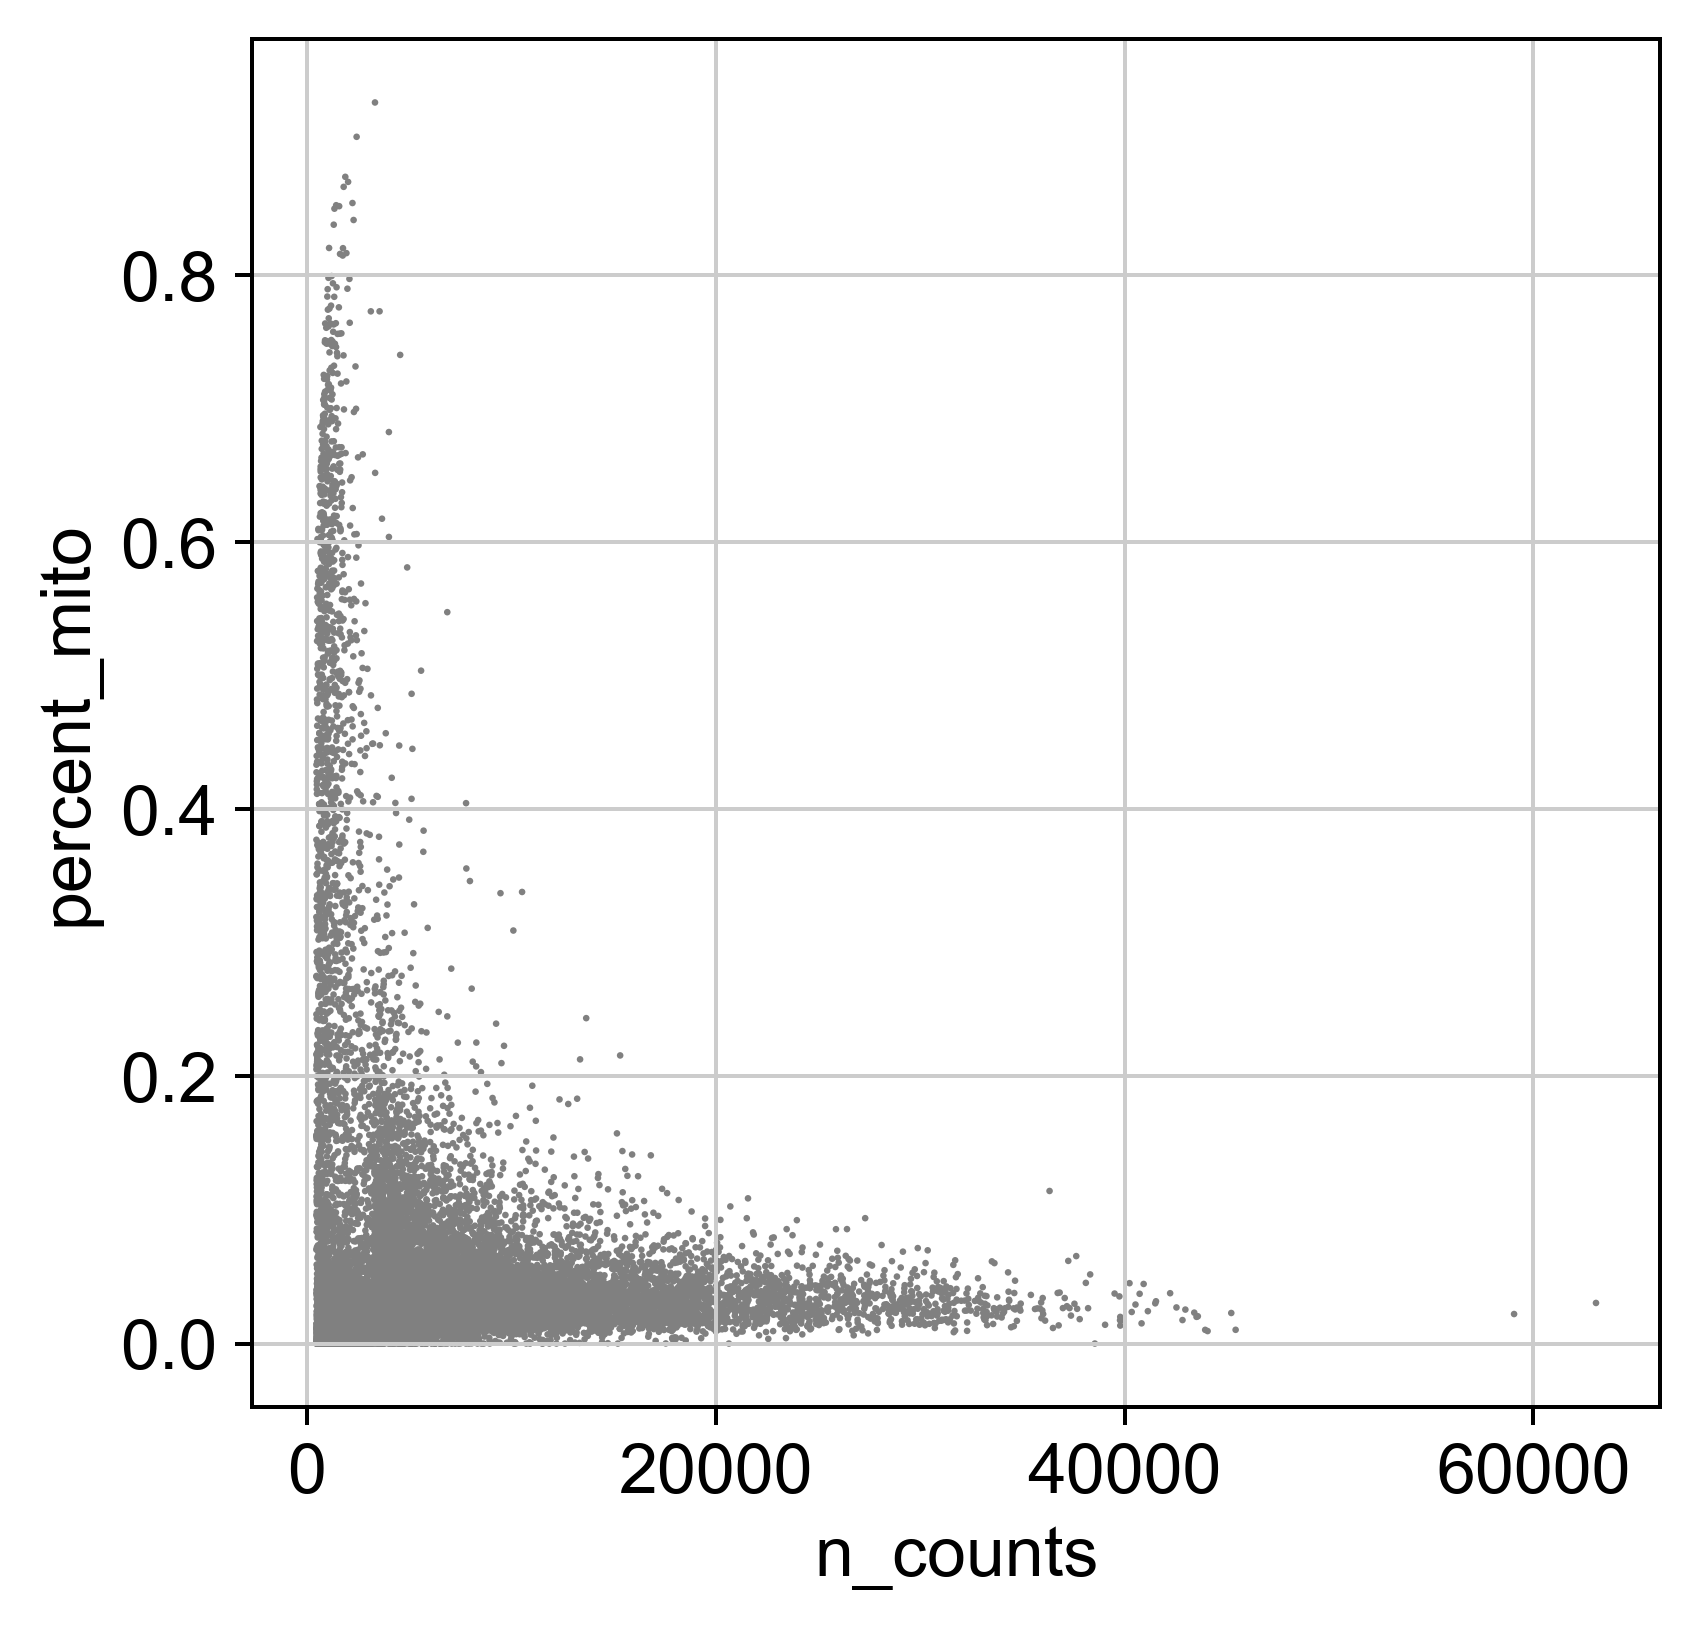

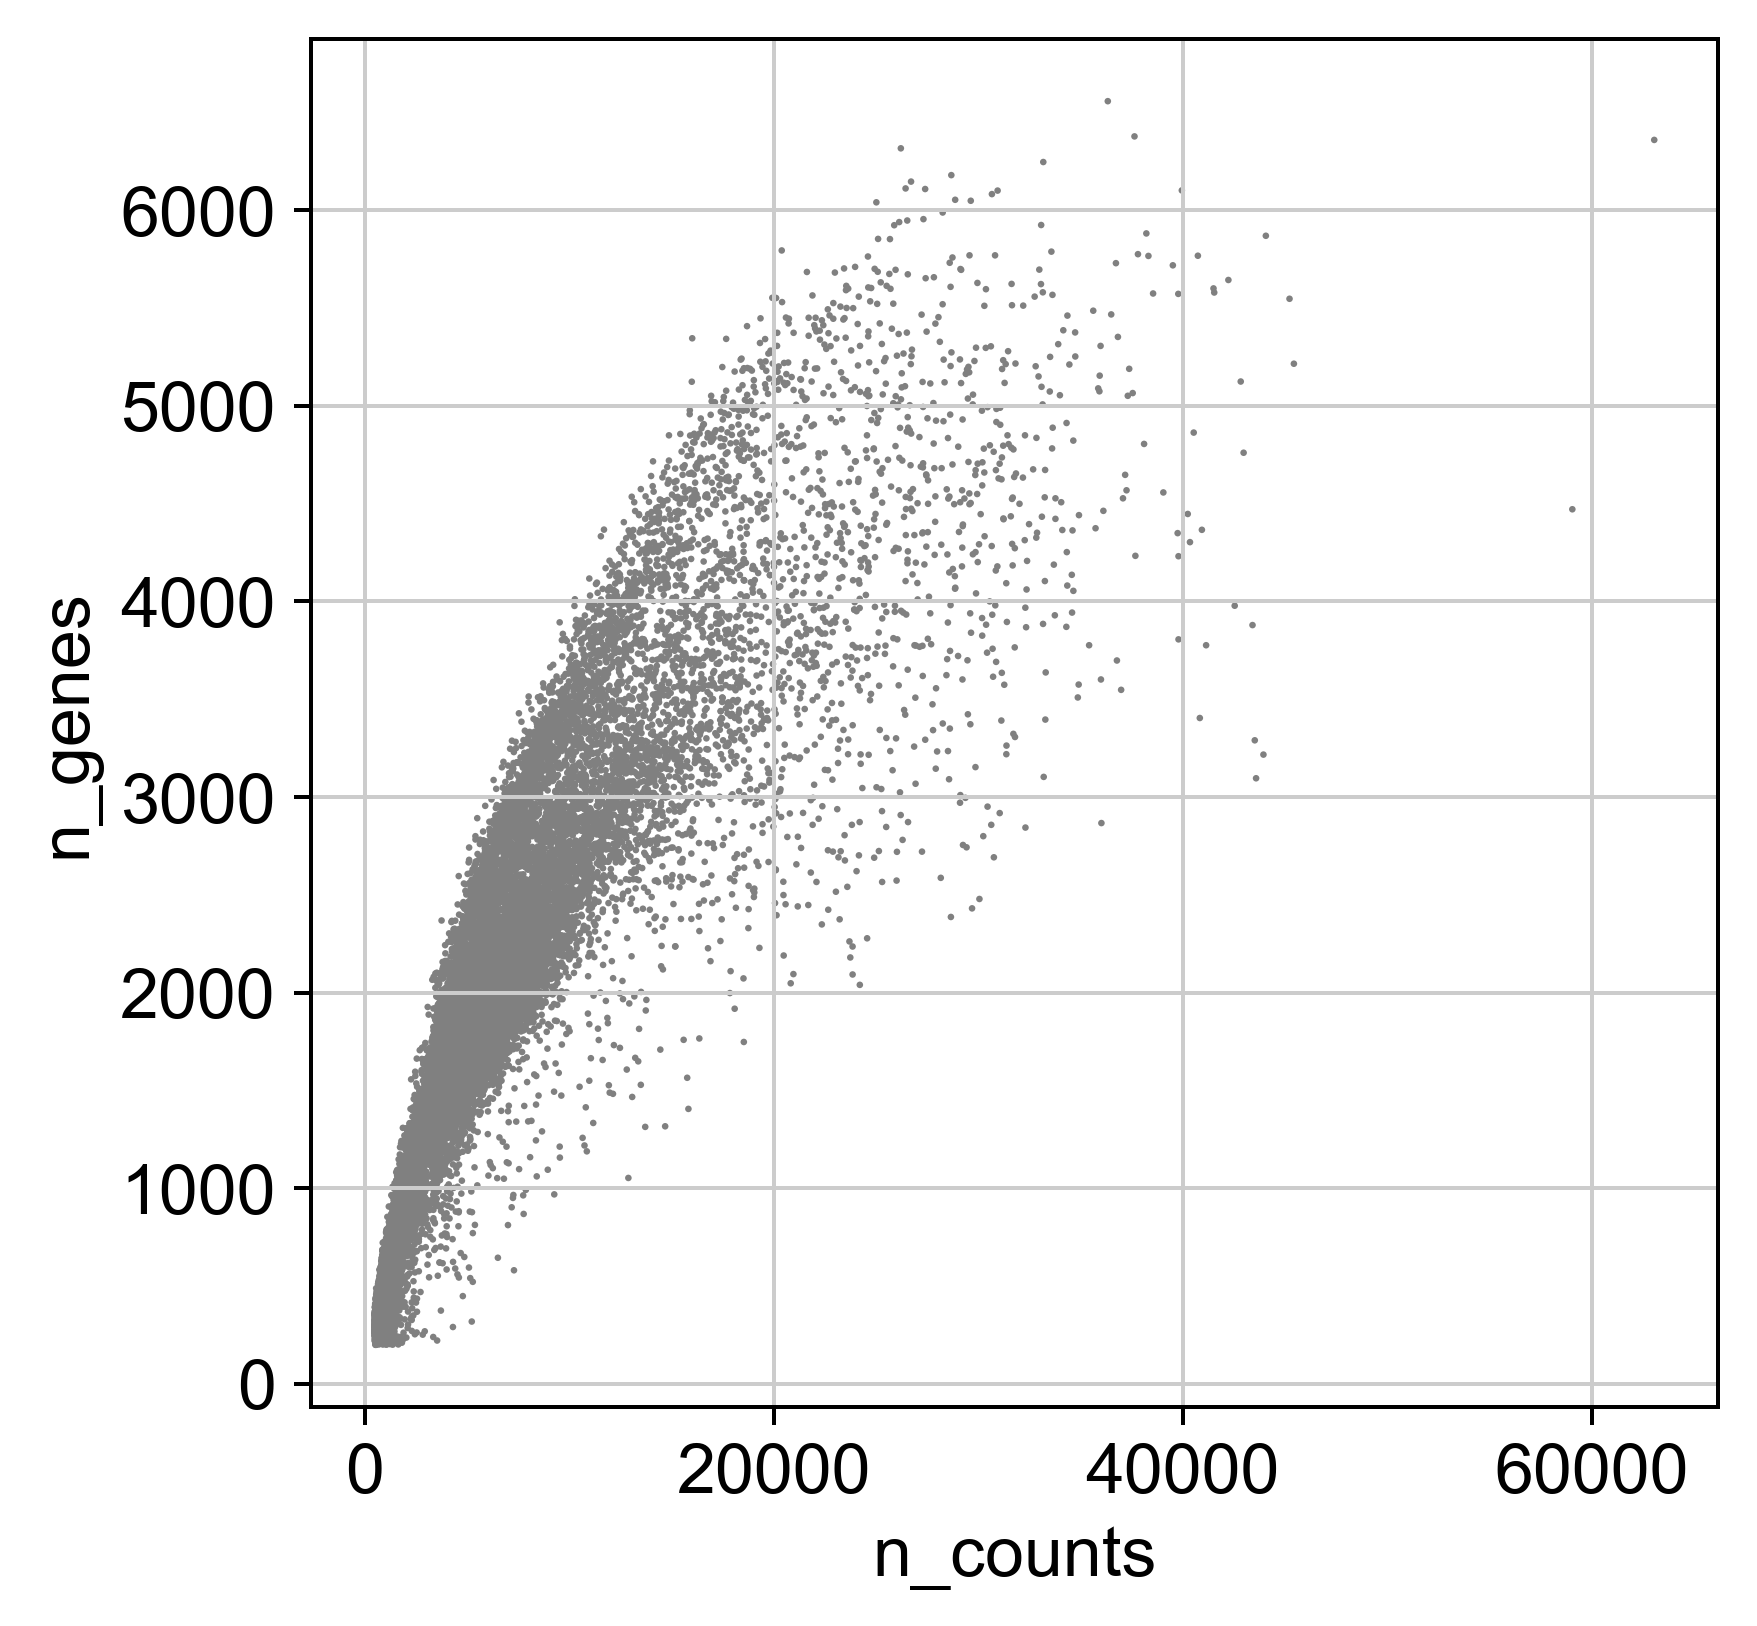

In [19]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [20]:
adata

AnnData object with n_obs × n_vars = 17189 × 19985 
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'

In [21]:
adata = adata[adata.obs.n_genes < 5000, :]
adata = adata[adata.obs.percent_mito < 0.10, :]


In [22]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell


Trying to set attribute `.X` of view, making a copy.


    finished (0:00:16)


In [23]:
sc.pp.log1p(adata)

C:\Users\tanjorh\.conda\envs\singlecellanalysis\lib\site-packages\scanpy\preprocessing\_simple.py:298: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


In [24]:
adata.raw = adata

In [25]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 3008


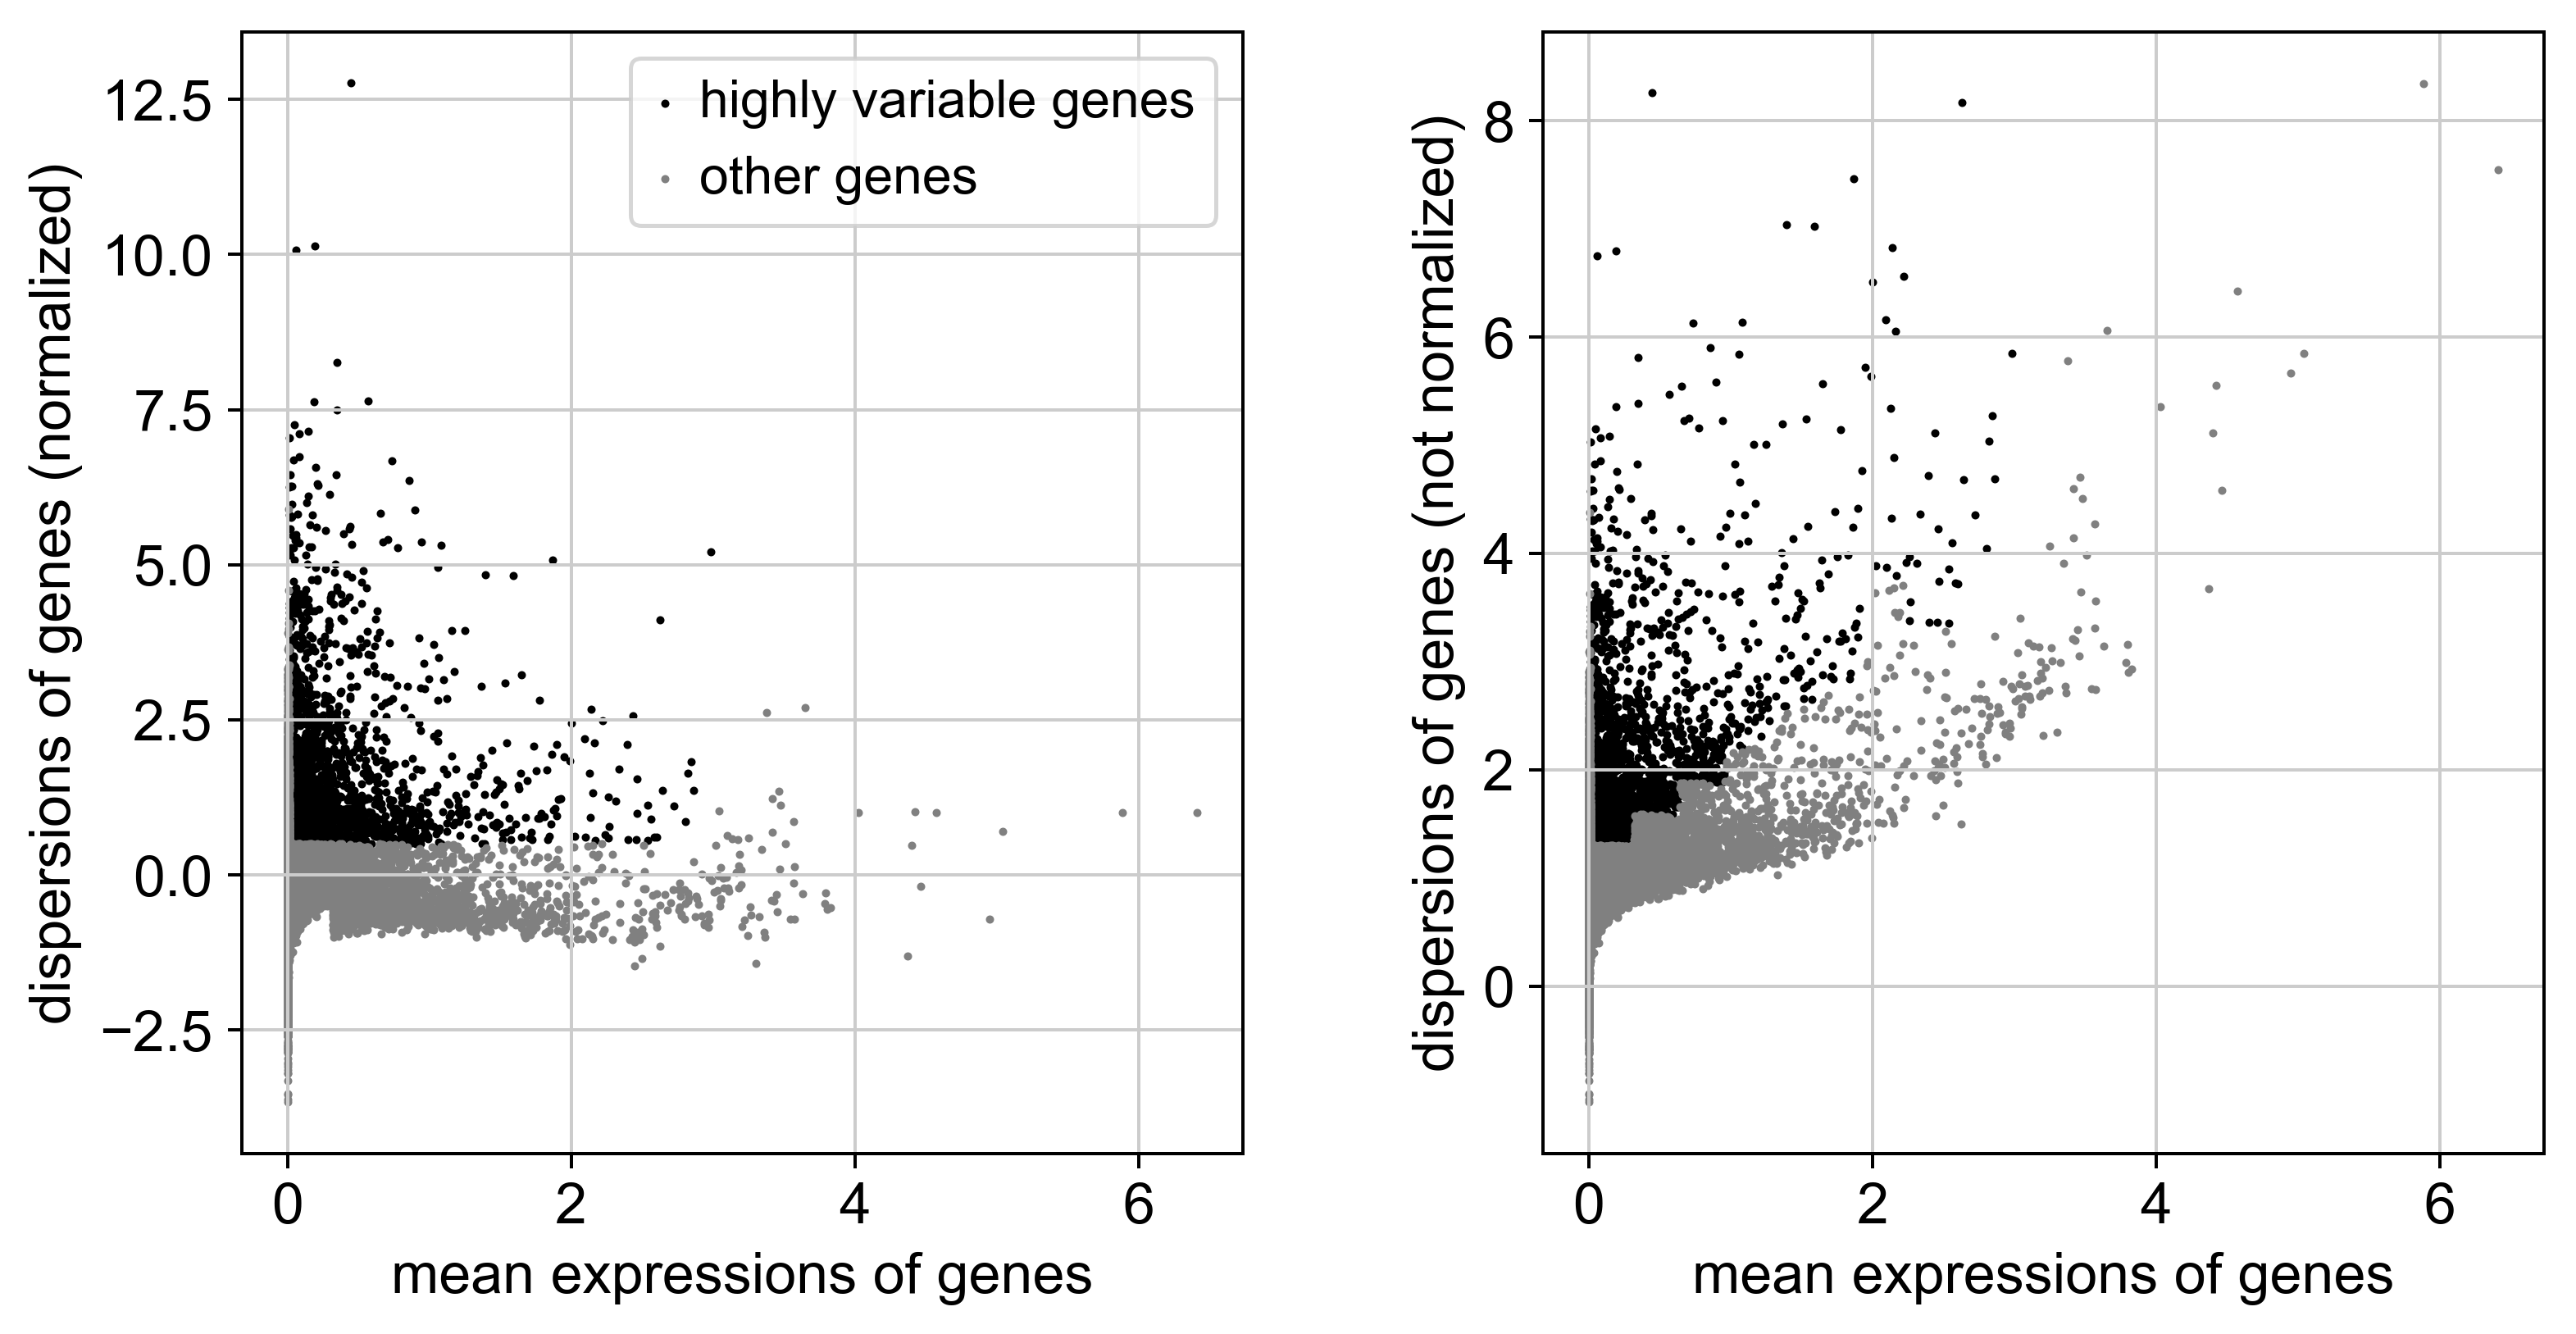

In [26]:
sc.pl.highly_variable_genes(adata)

In [27]:
sc.pp.filter_genes(adata, min_counts=1)

filtered out 61 genes that are detected in less than 1 counts


In [28]:
print(np.any(adata.X.sum(axis=0) == 0))
print(np.any(adata.X.sum(axis=1) == 0))

False
False


In [29]:
#adata = adata[:,adata.X.sum(axis=0) > 0]
#sc.pp.filter_genes(adata, min_counts=1)

In [30]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:02:46)


In [31]:
sc.pp.scale(adata, max_value=10)

In [32]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:01)


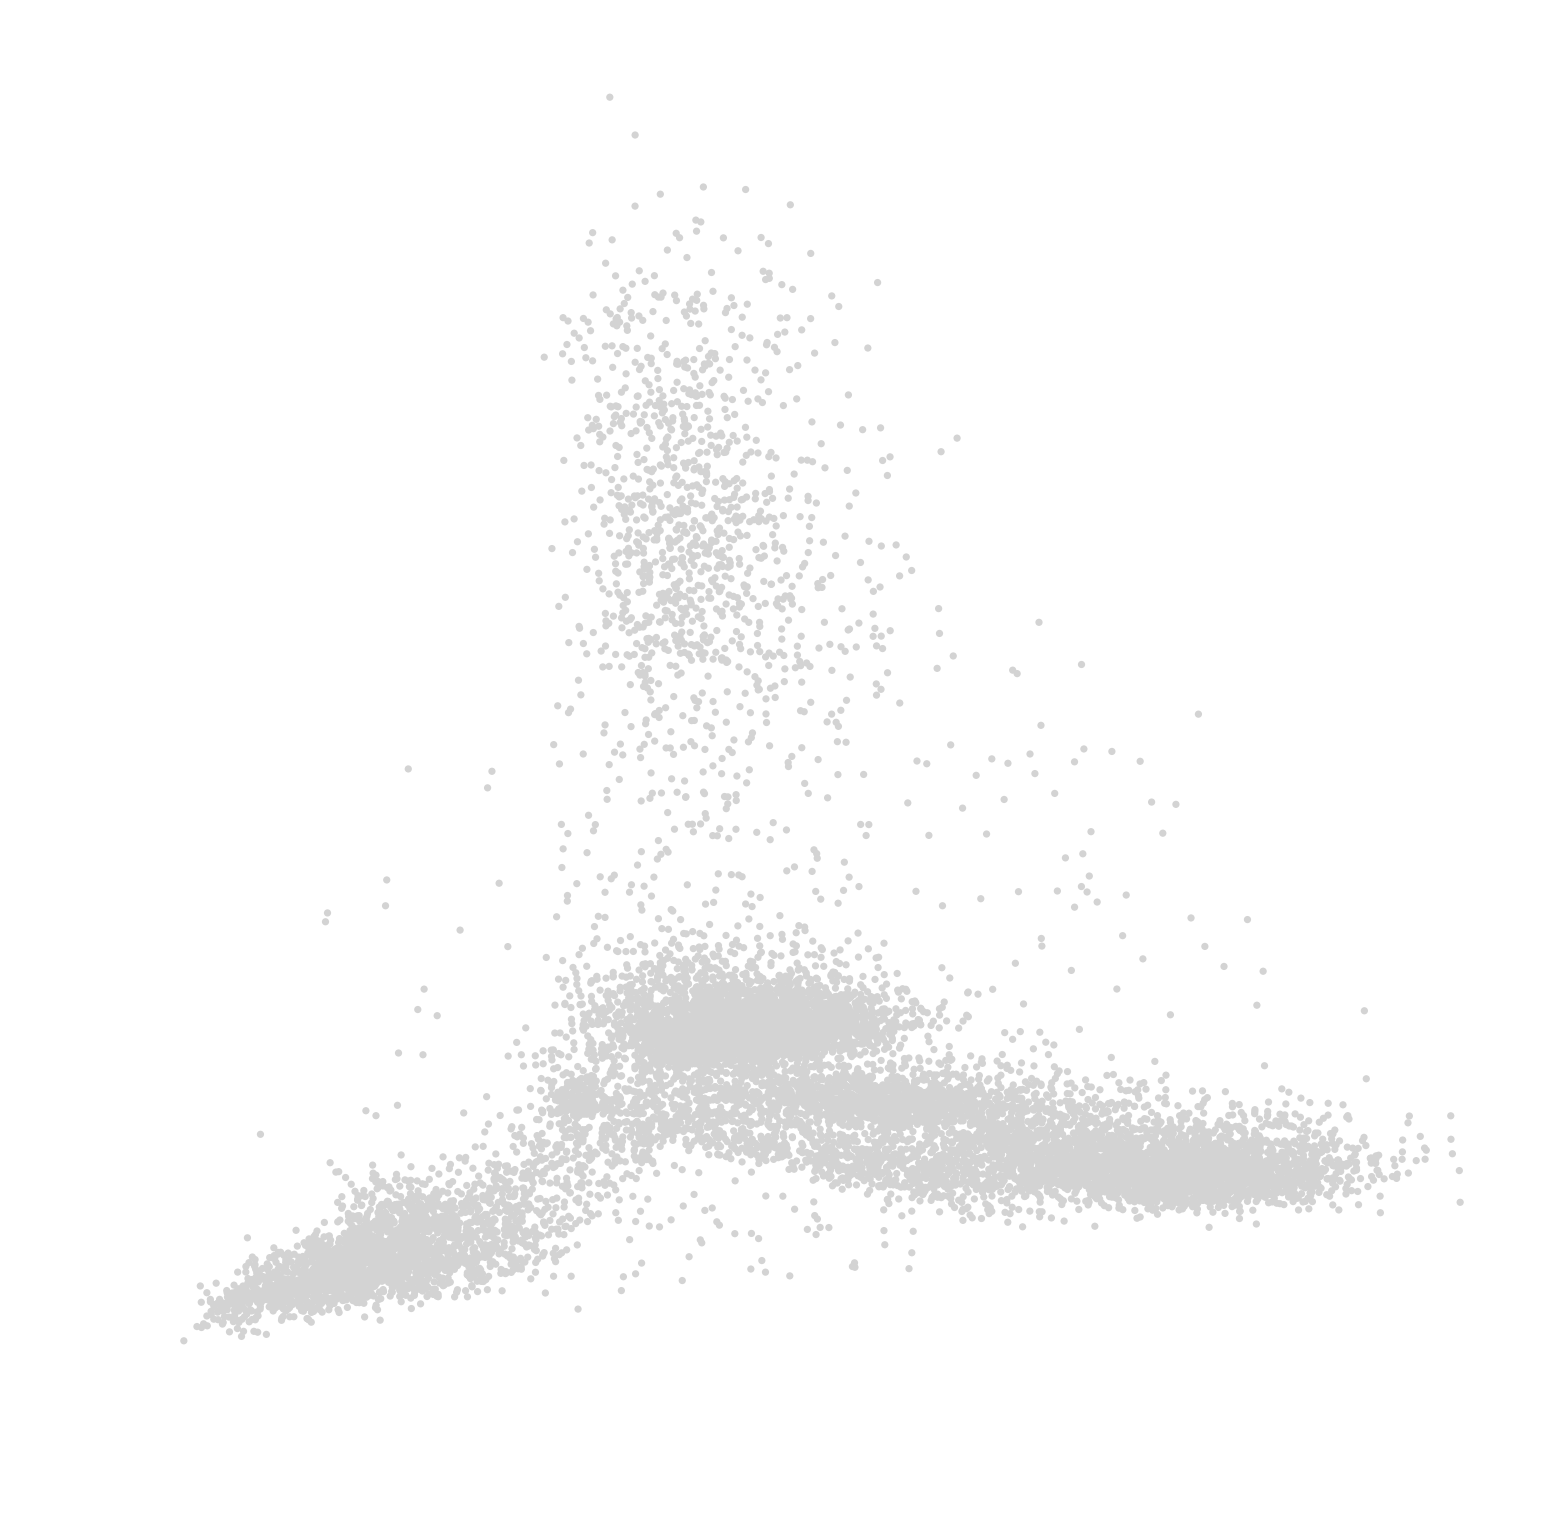

In [33]:
sc.pl.pca(adata)

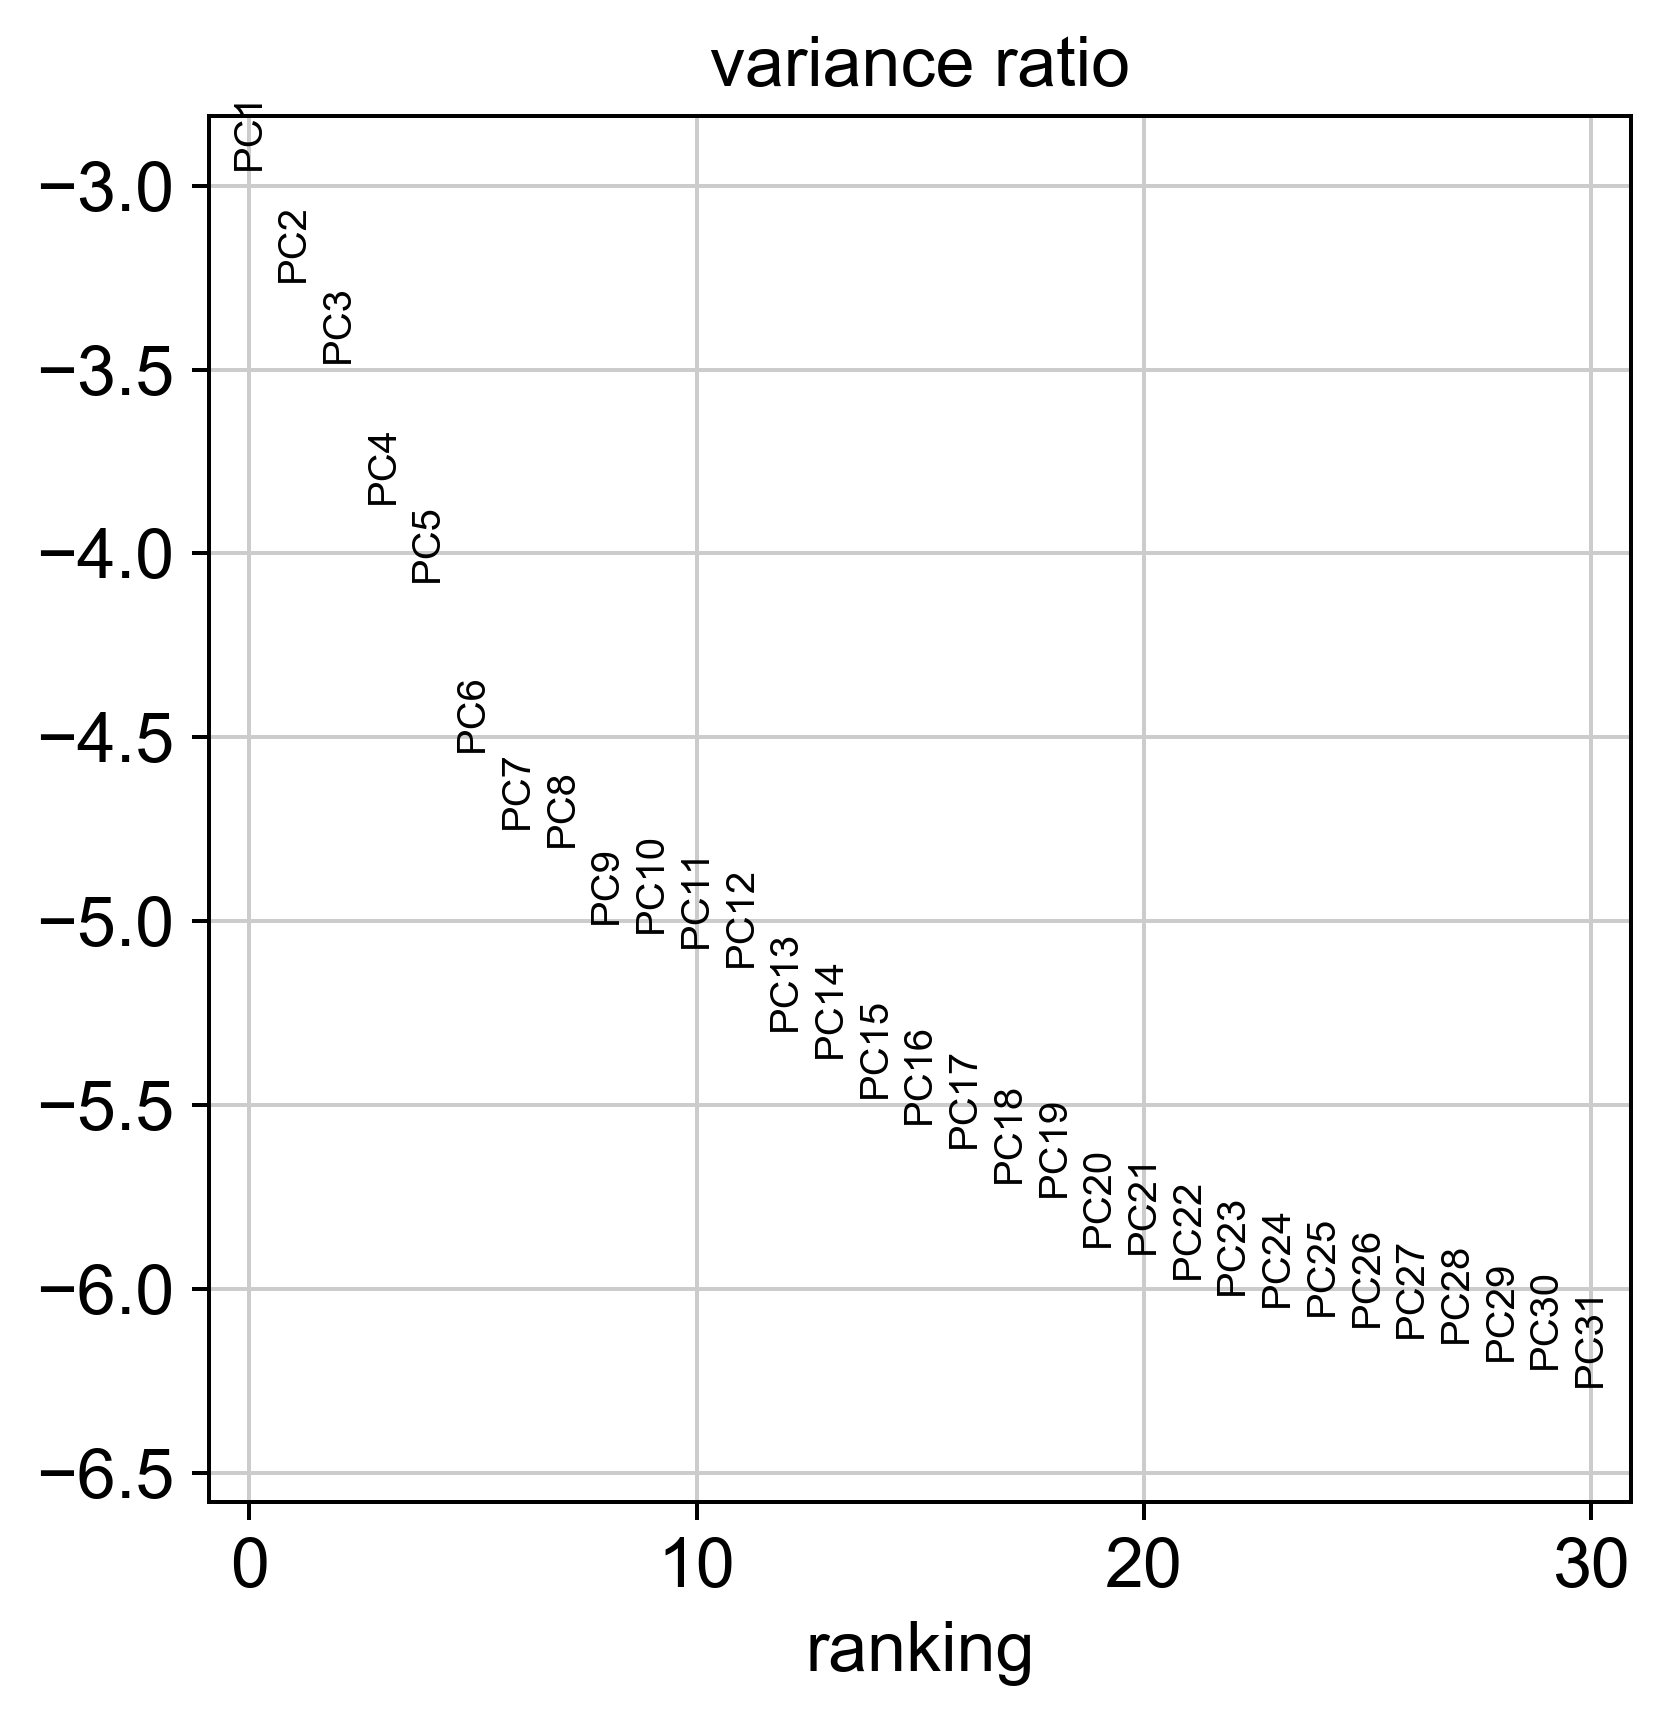

In [34]:
sc.pl.pca_variance_ratio(adata, log=True)

In [35]:
adata.write(results_file)

In [36]:
sc.pp.neighbors(adata,method = 'umap')
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50


C:\Users\tanjorh\.conda\envs\singlecellanalysis\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\..\..\.conda\envs\singlecellanalysis\lib\site-packages\umap\rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
C:\Users\tanjorh\.conda\envs\singlecellanalysis\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\.

    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


In [37]:
sc.tl.leiden(adata,  resolution= 1.0, key_added='leiden_r1.0')

running Leiden clustering
    finished: found 35 clusters and added
    'leiden_r1.0', the cluster labels (adata.obs, categorical) (0:00:02)


In [38]:
sc.tl.louvain(adata, resolution= 1.0,key_added='louvain_r1.0')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 31 clusters and added
    'louvain_r1.0', the cluster labels (adata.obs, categorical) (0:00:01)


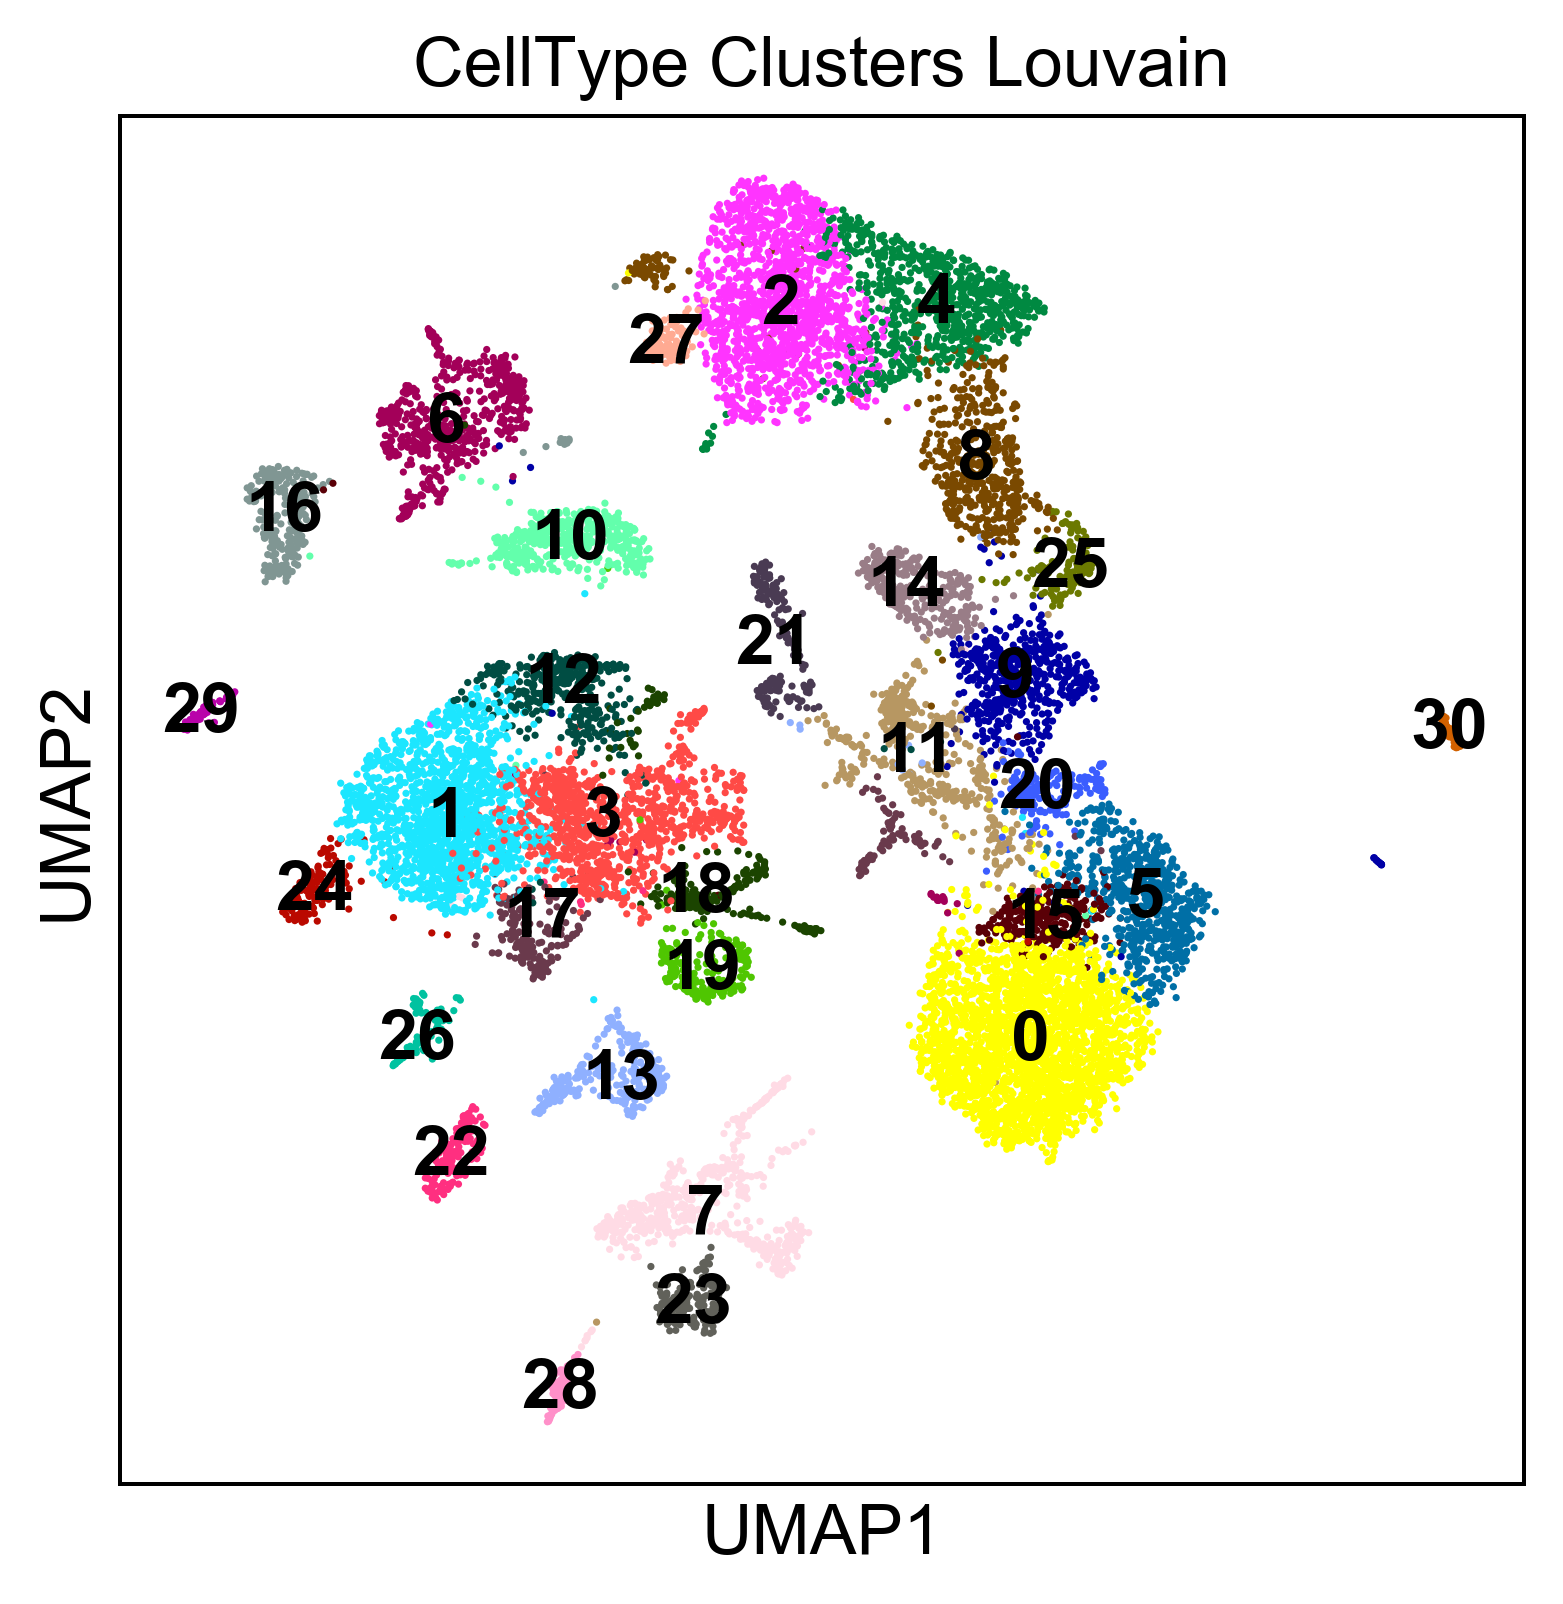

In [39]:
sc.pl.umap(adata, color=['louvain_r1.0'],legend_loc='on data', title = 'CellType Clusters Louvain', 
           frameon = True, save='_celltype_louvain_clusters.pdf')

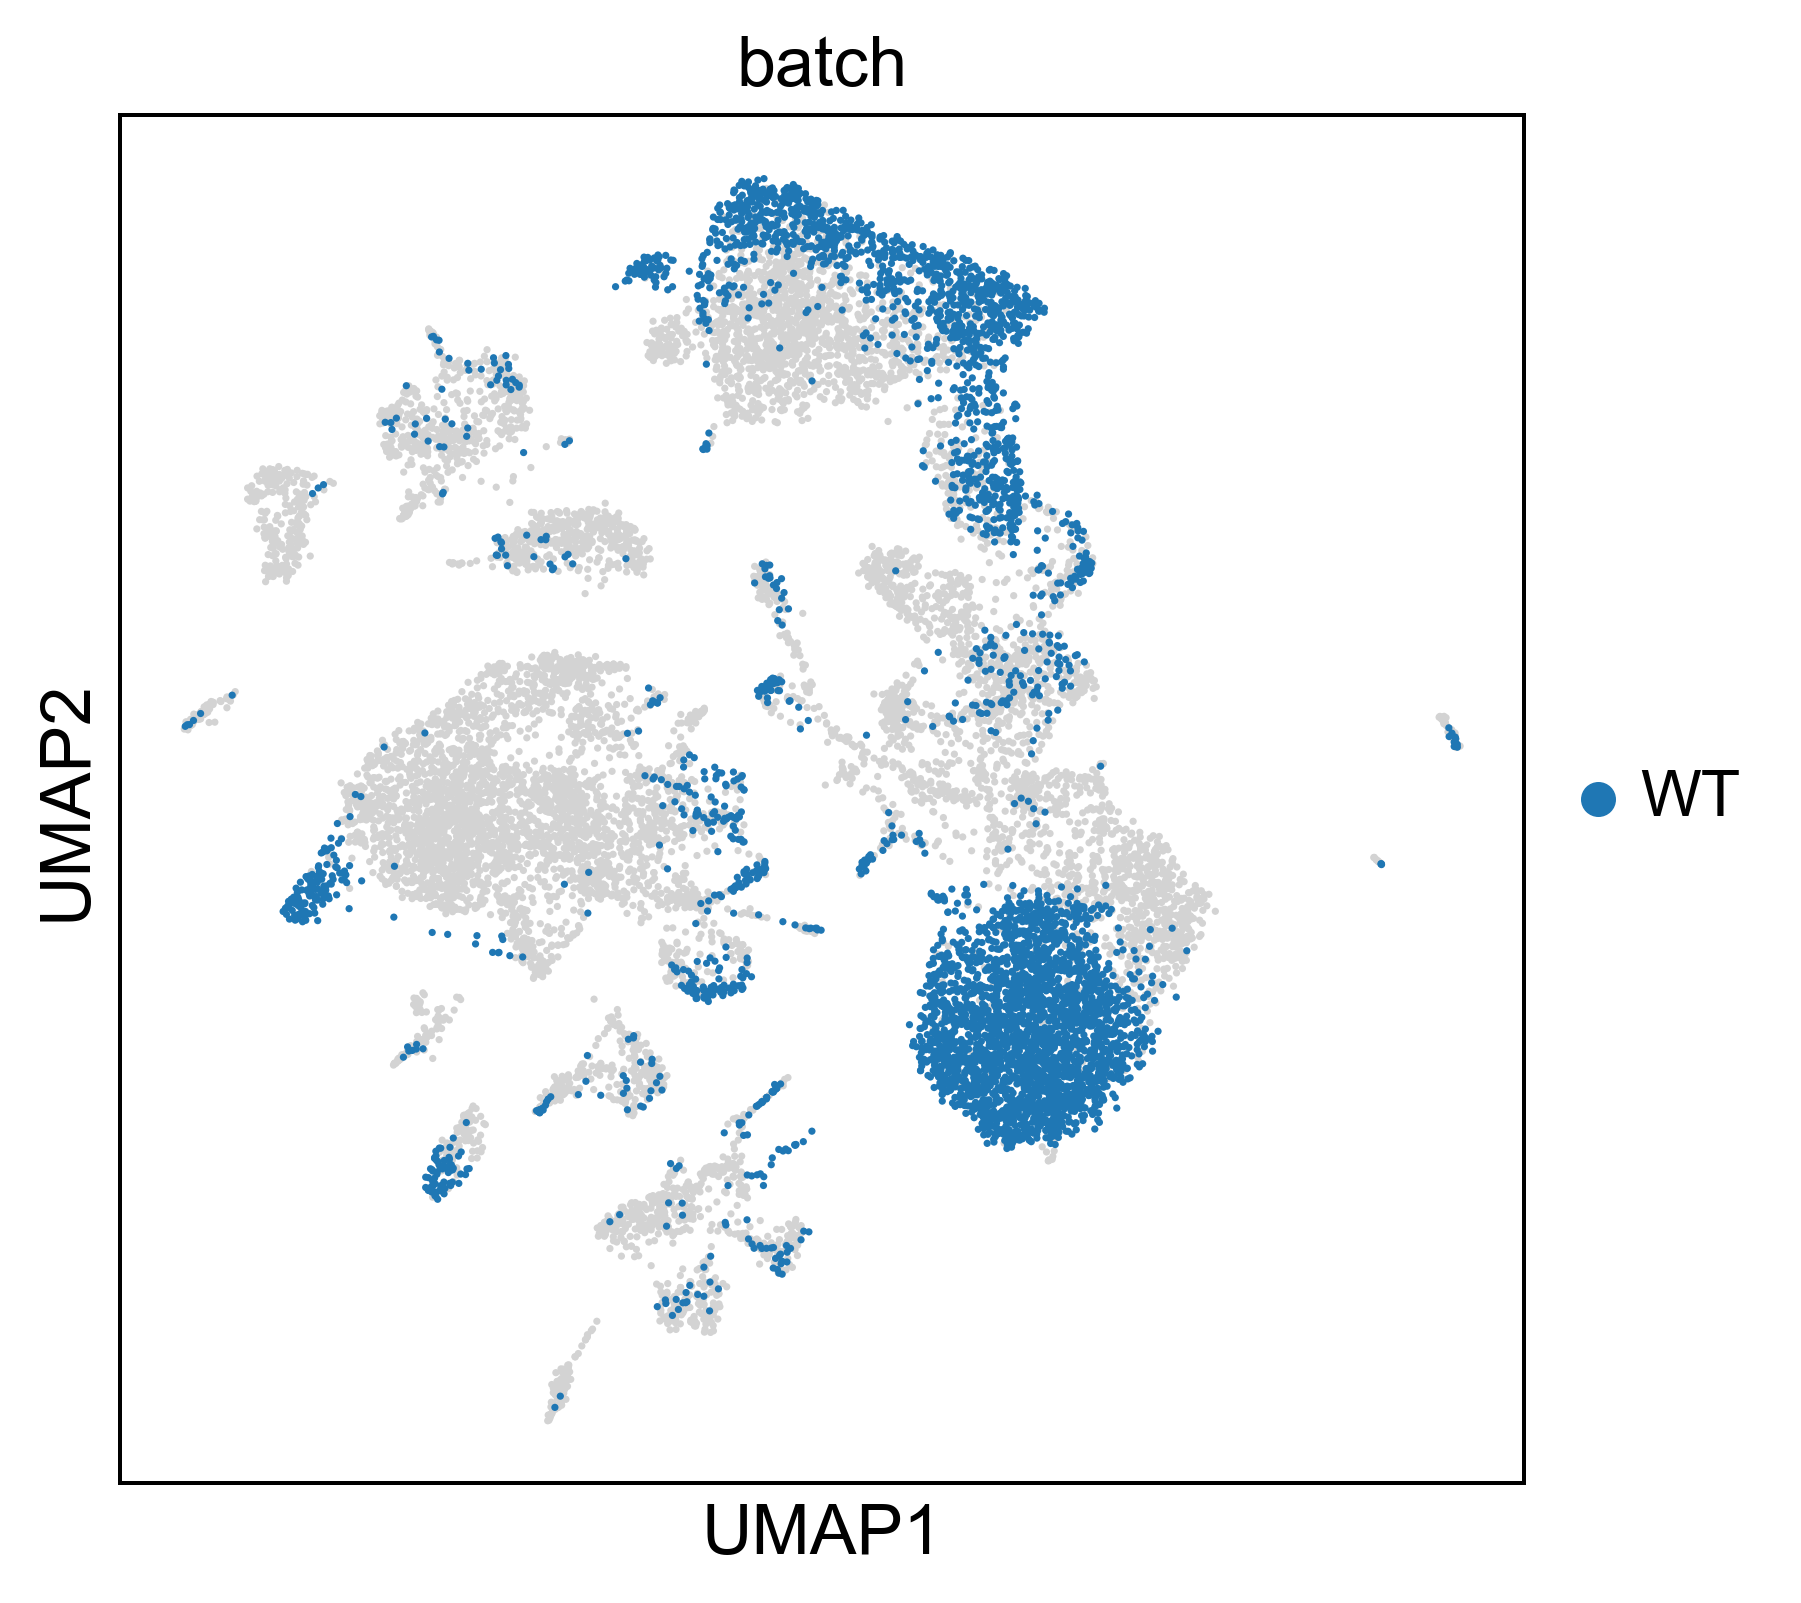

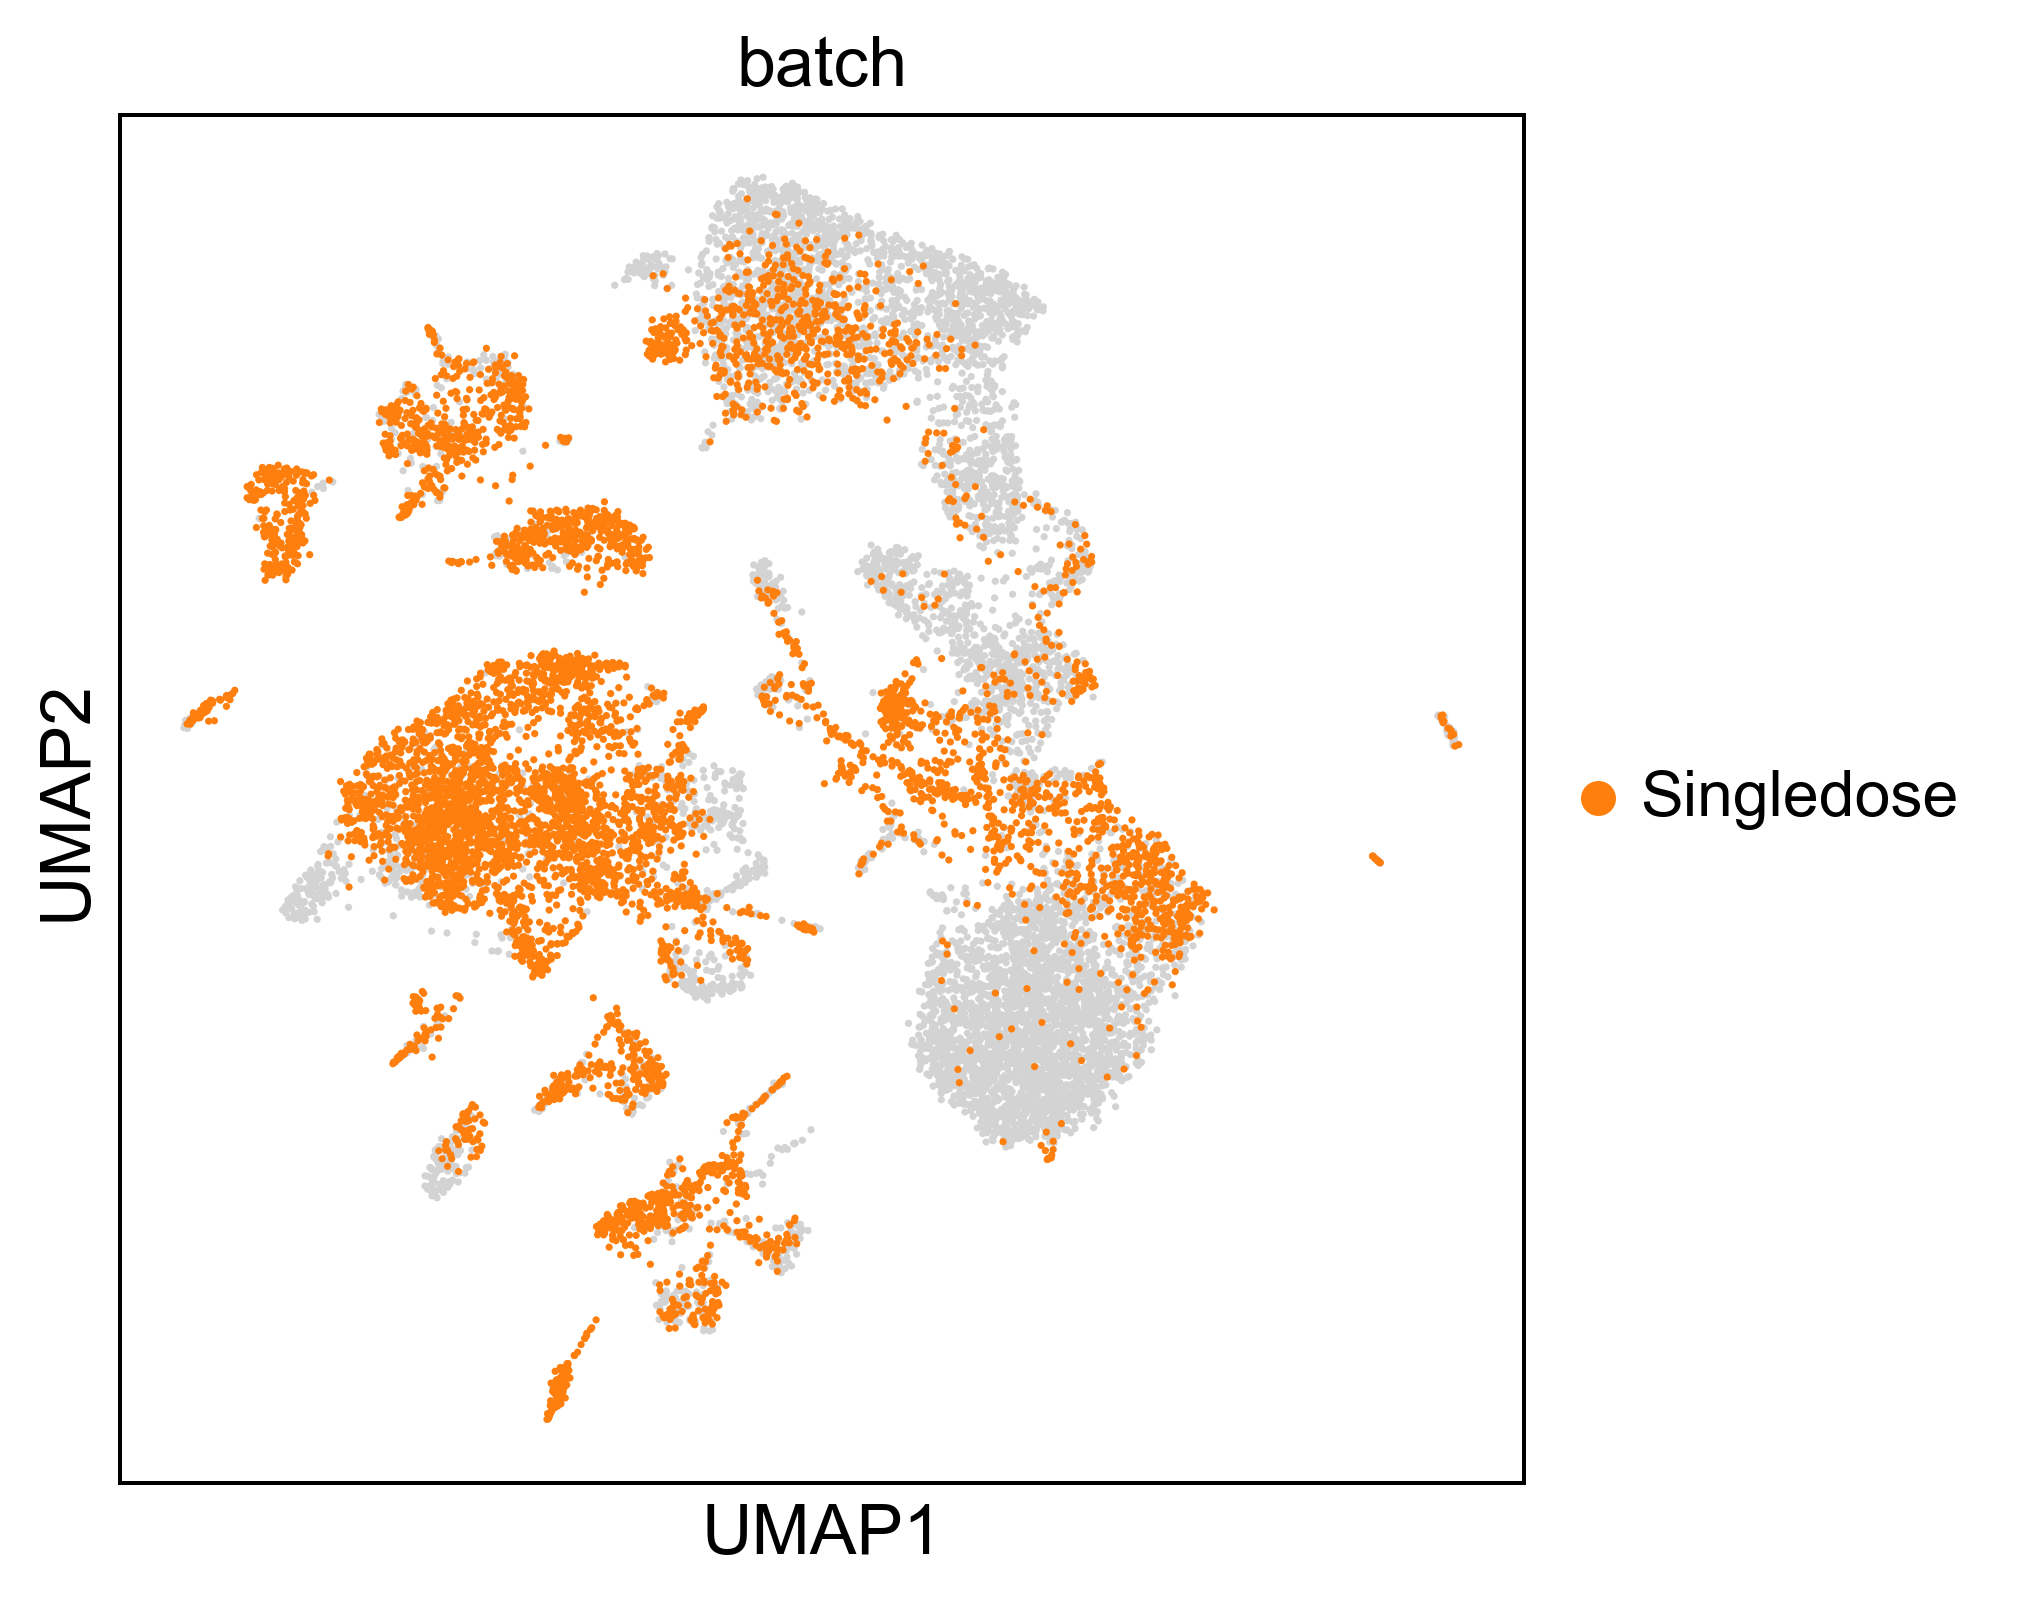

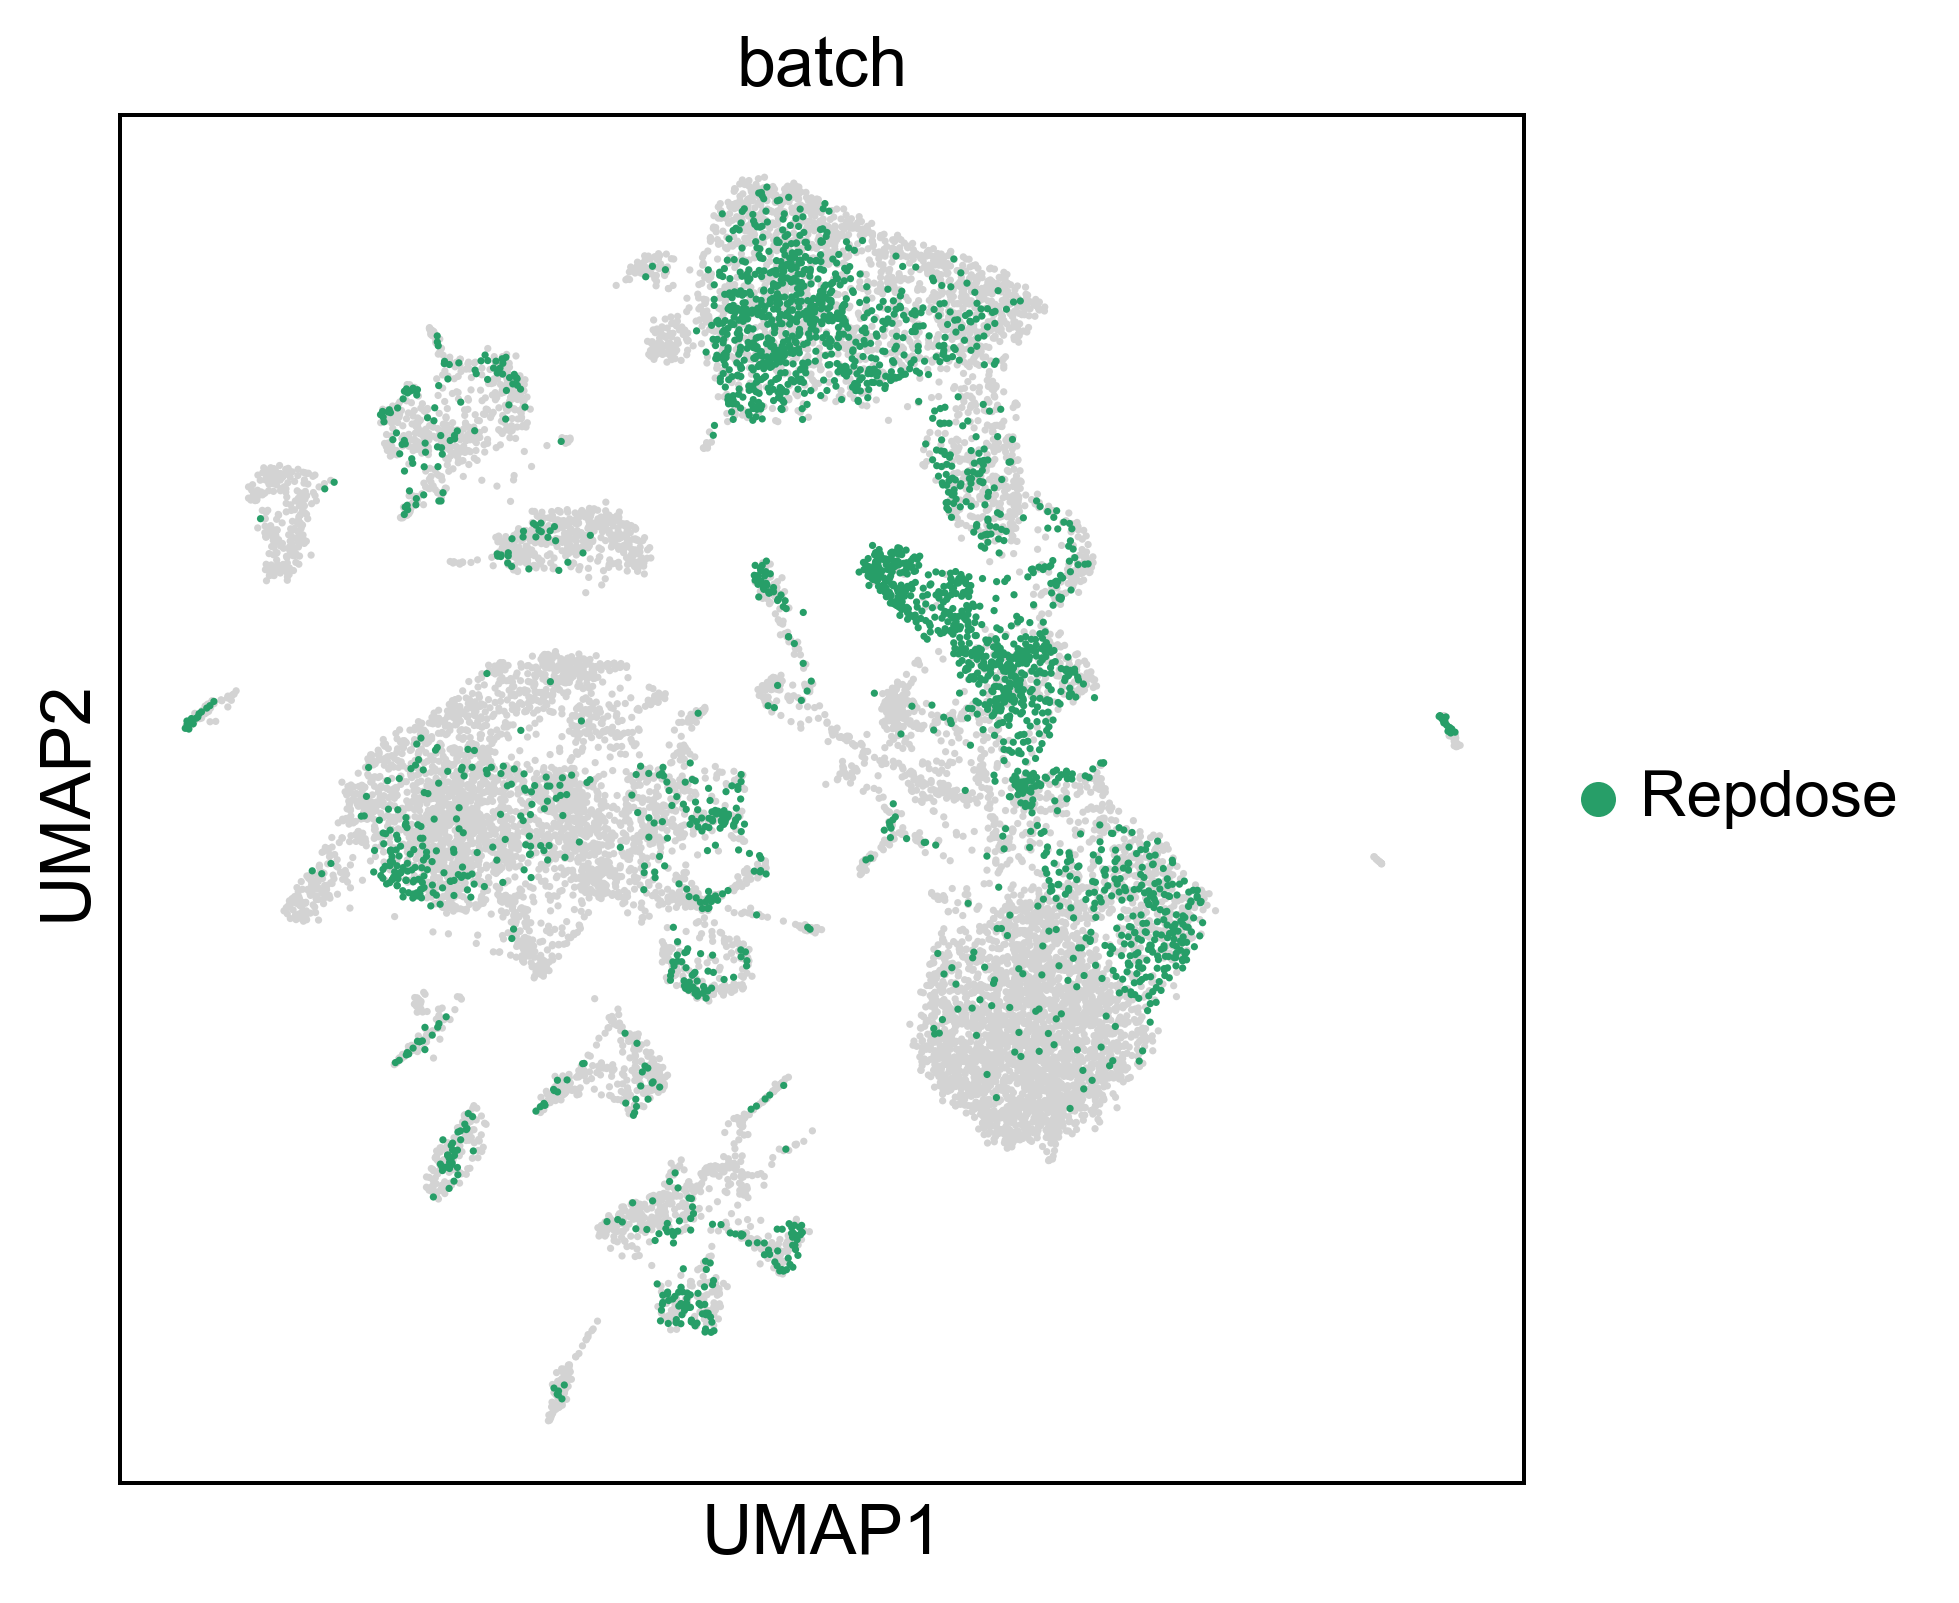

In [40]:
sc.pl.umap(adata, color=['batch'], groups='WT', frameon = True, save = '_wtuntreated.pdf')
sc.pl.umap(adata, color=['batch'], groups='Singledose', frameon = True, save= '_singledose.pdf')
sc.pl.umap(adata, color=['batch'], groups='Repdose', frameon = True, save = '_repdose.pdf')


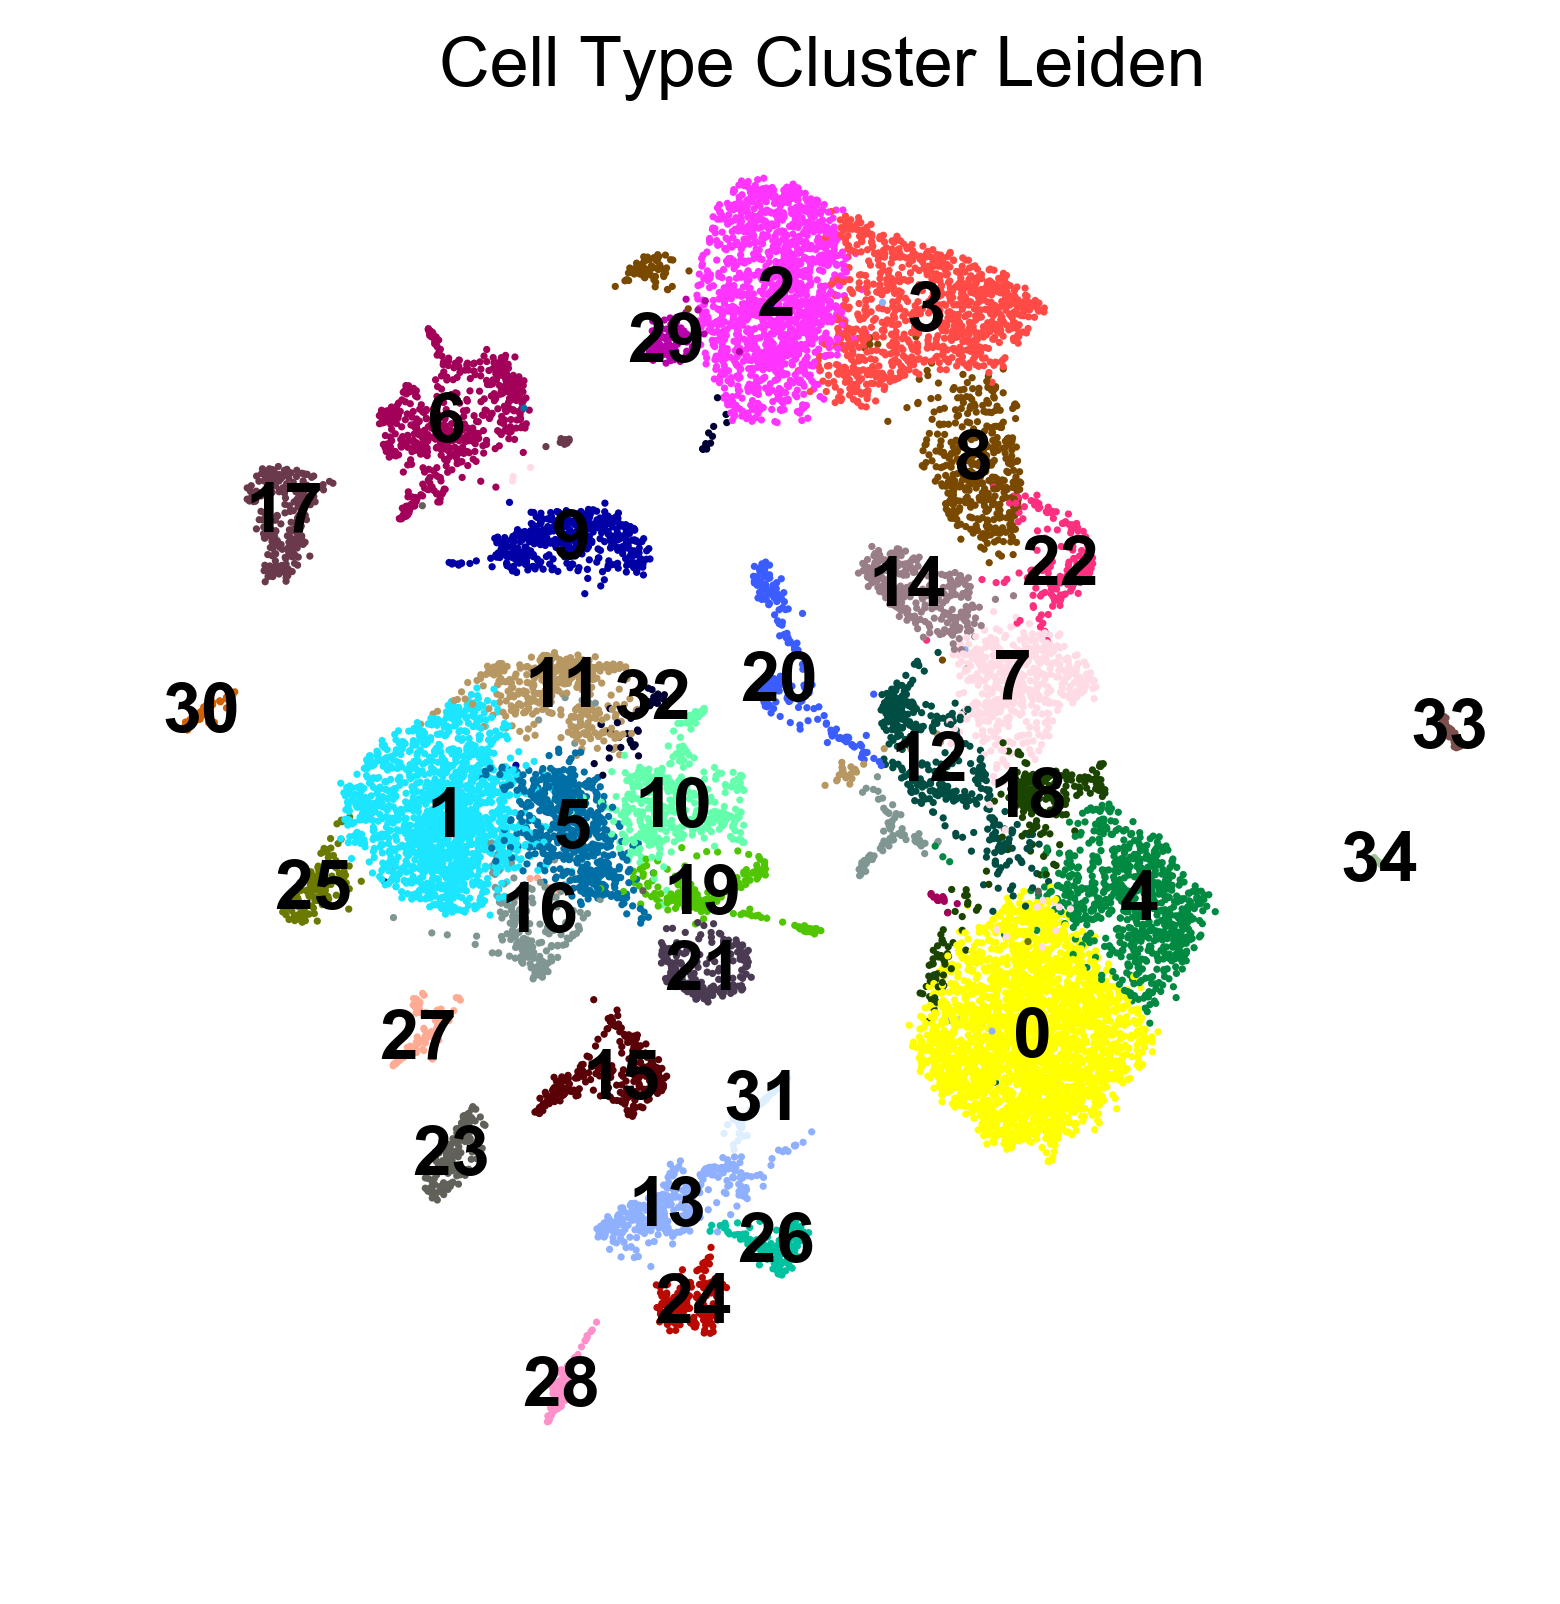

In [41]:
sc.pl.umap(adata, color=['leiden_r1.0'],title = 'Cell Type Cluster Leiden',legend_loc='on data',save='_celltype_leiden_clusters.pdf')

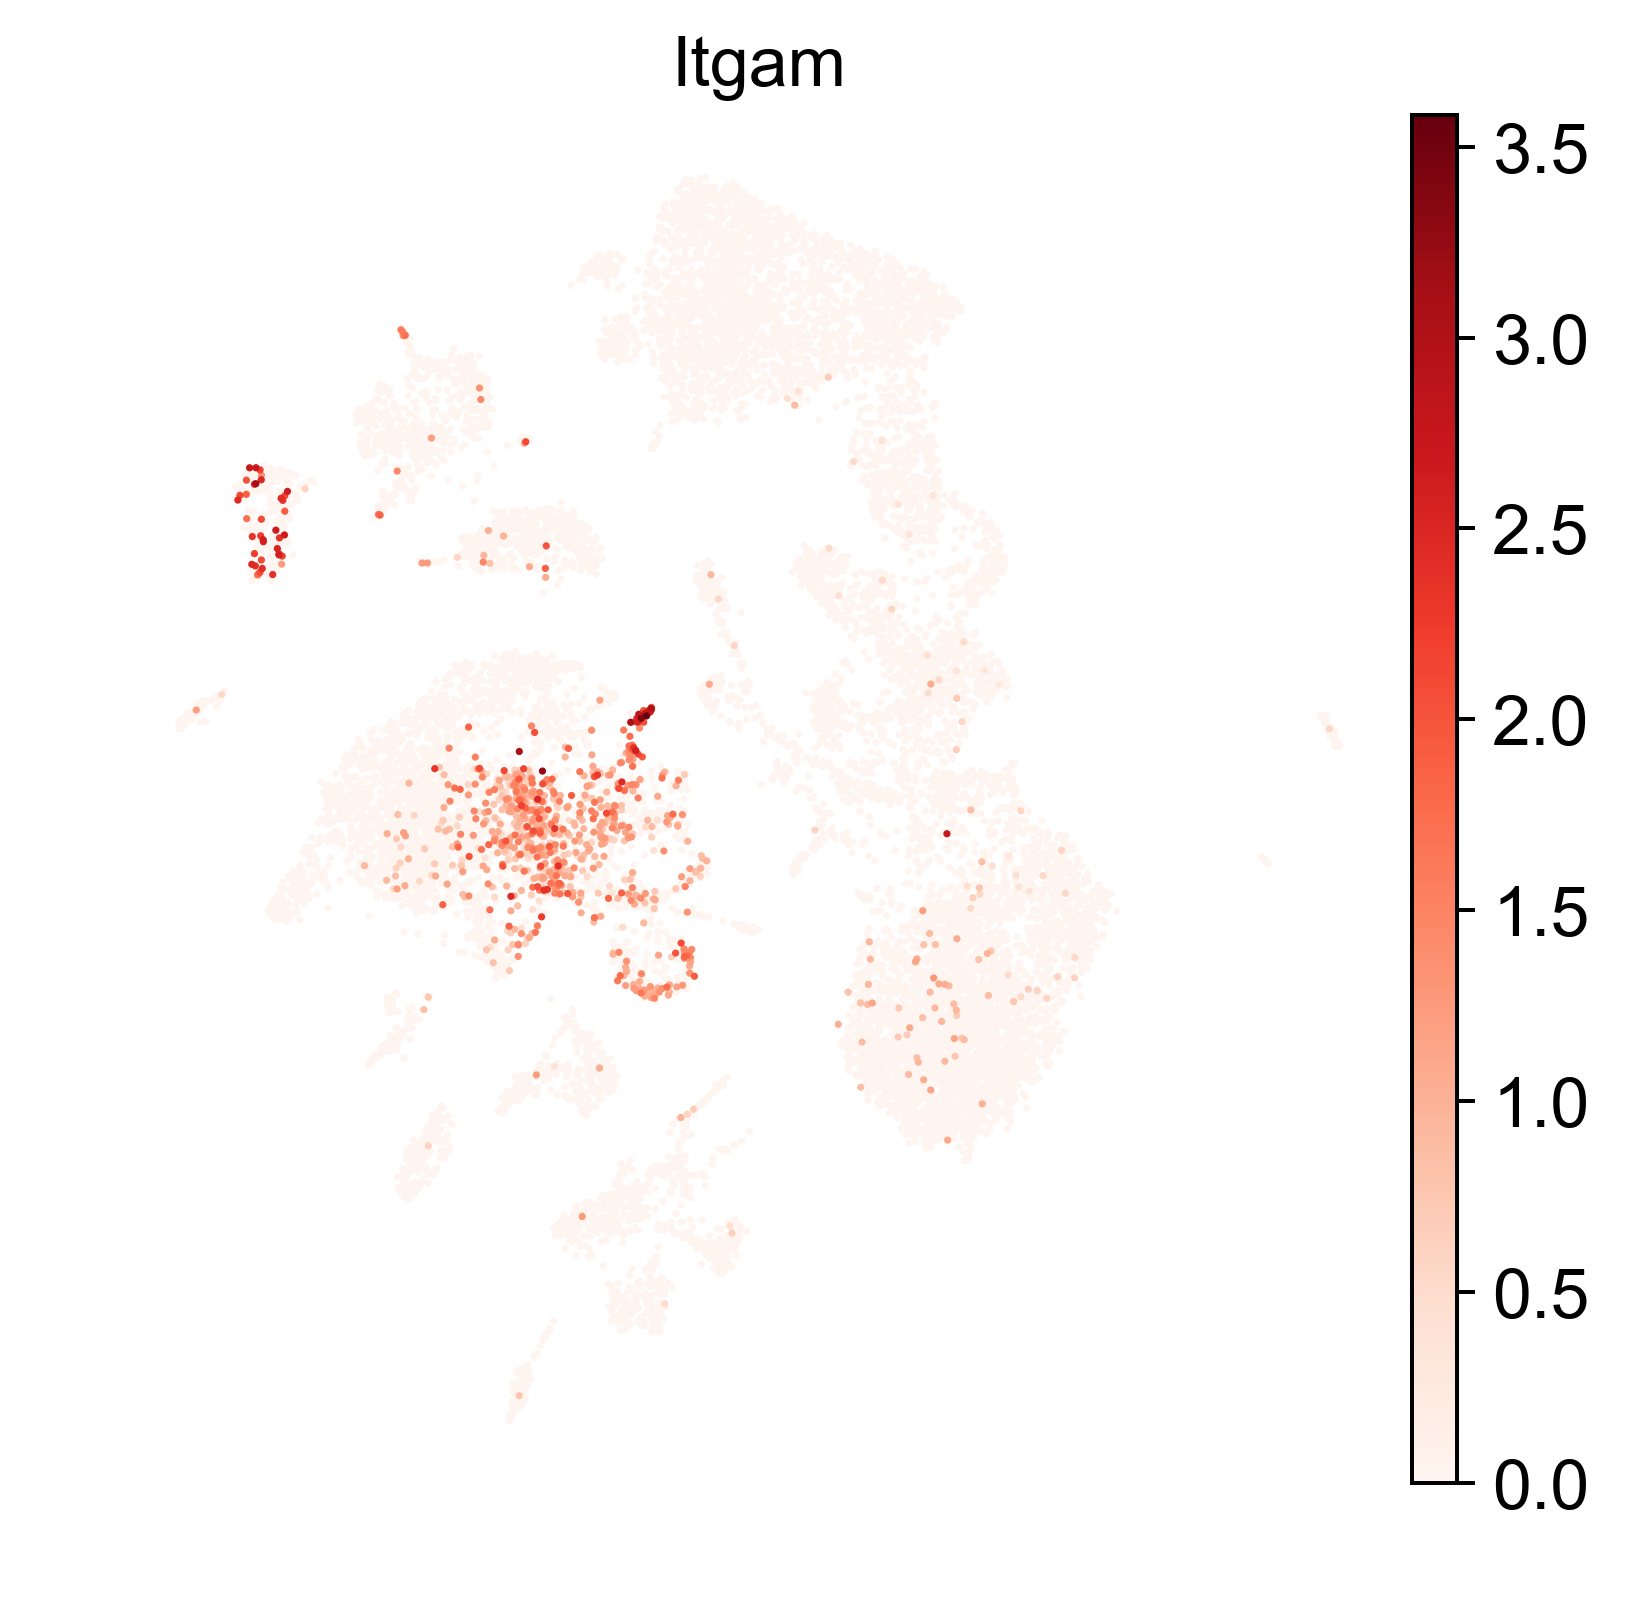

In [42]:
sc.pl.umap(adata,color =["Itgam"], use_raw=True, show=False, ncols= 2,color_map = 'Reds');

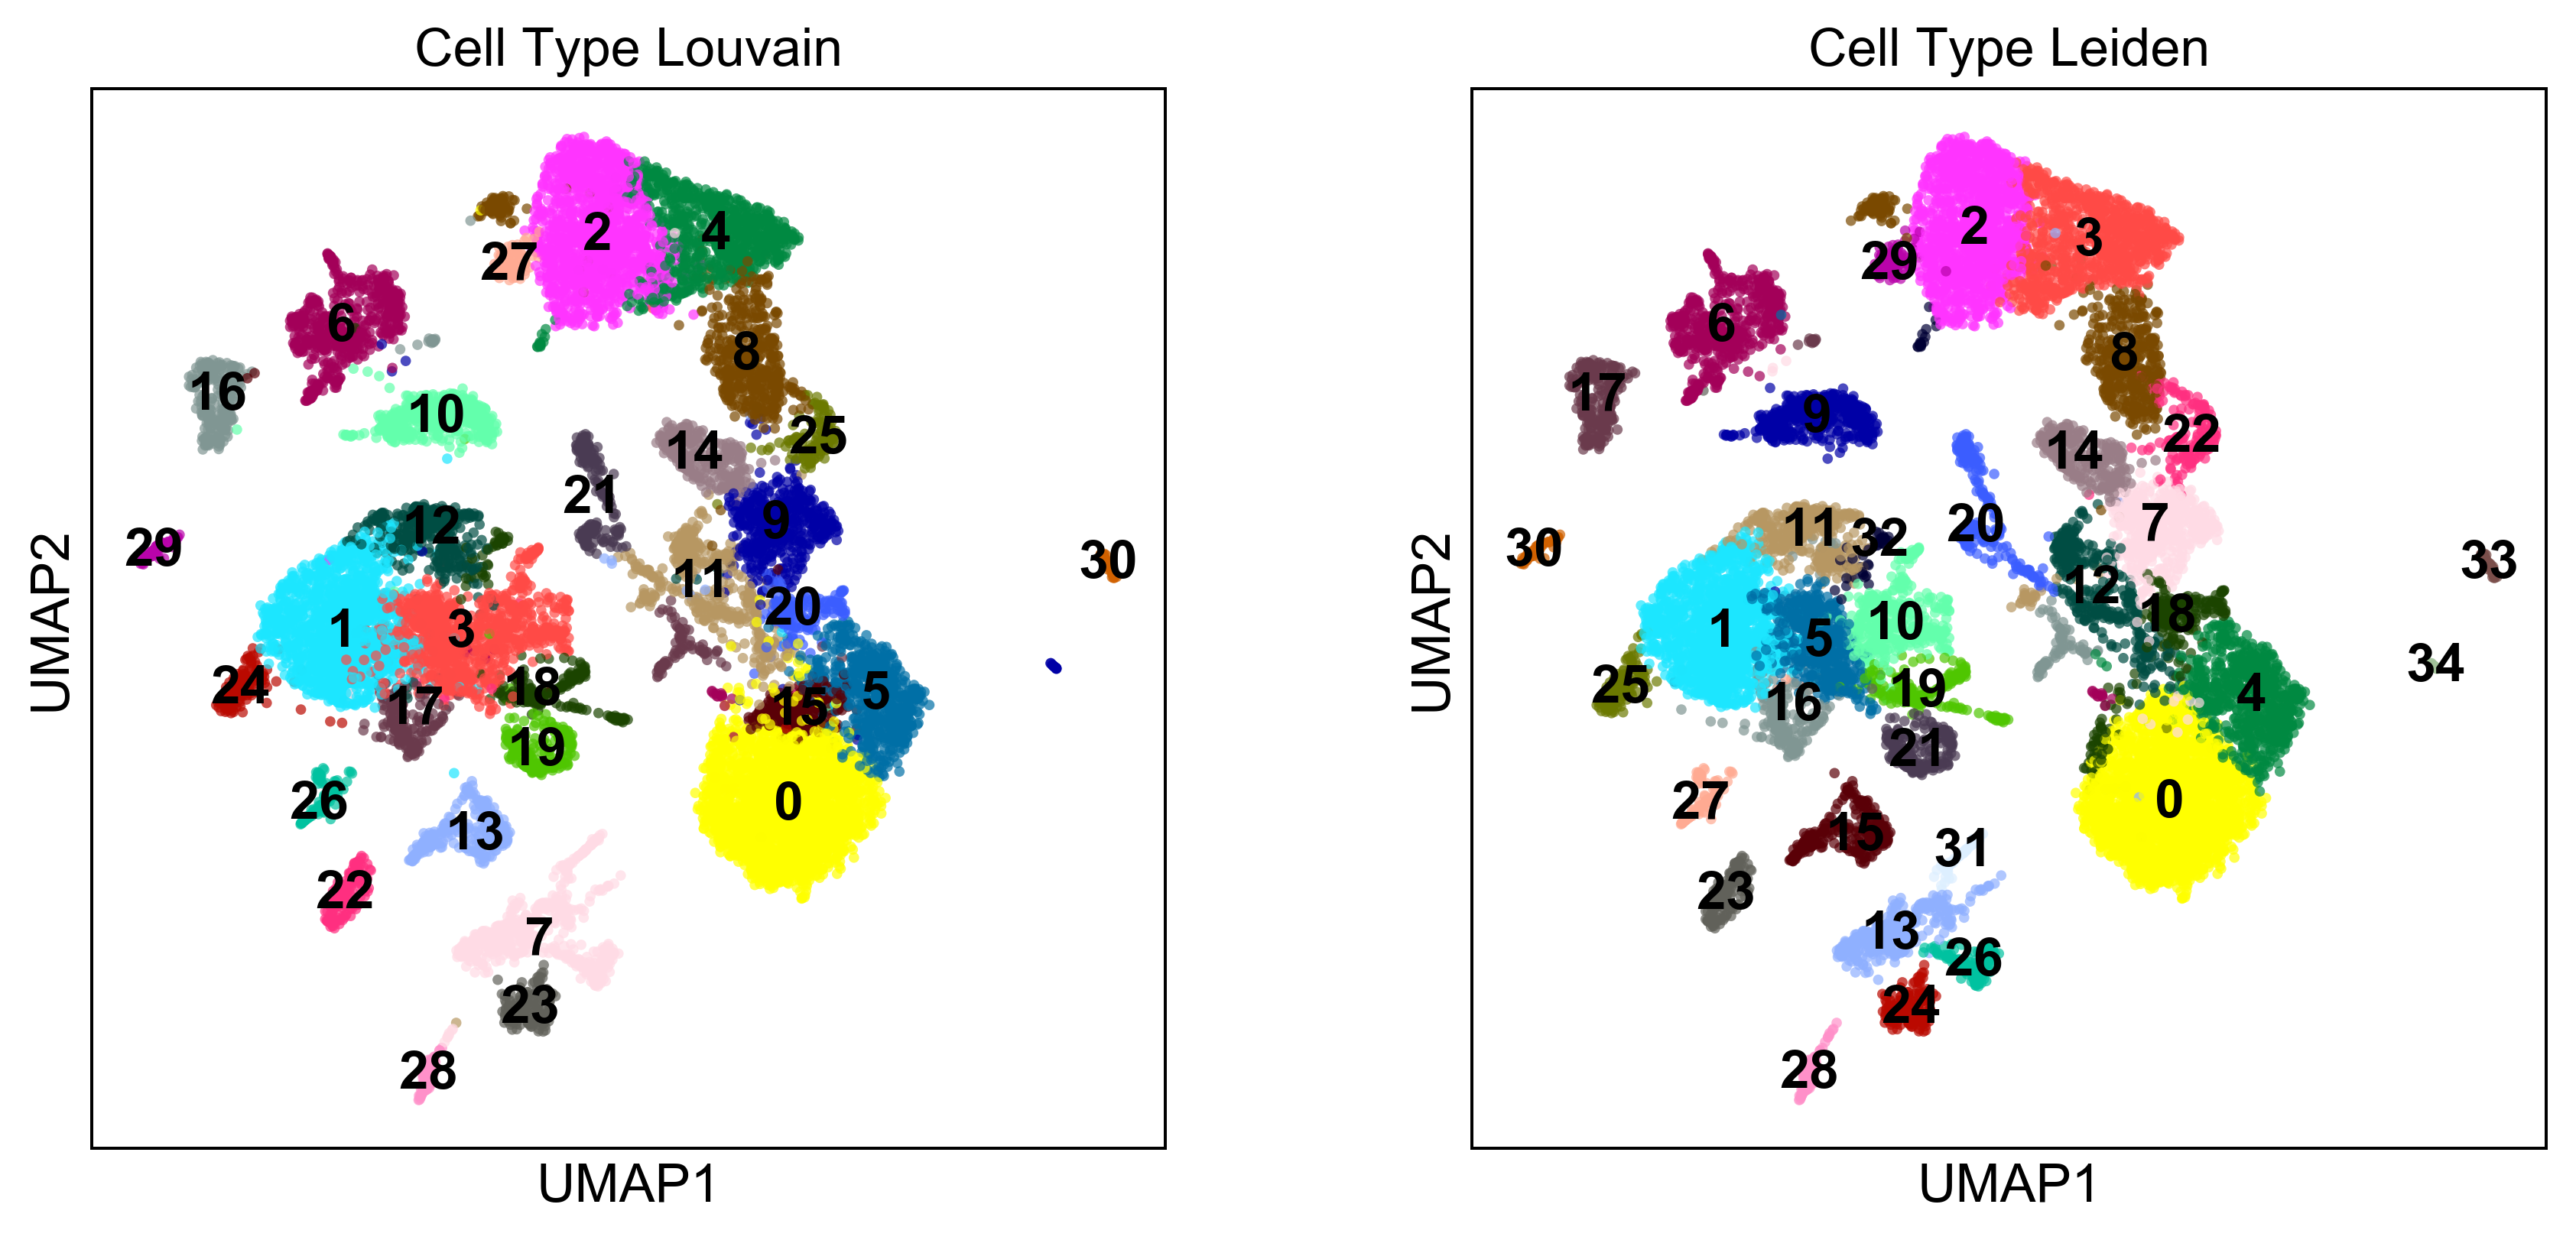

In [43]:
sc.pl.umap(adata, color=['louvain_r1.0','leiden_r1.0'], title=['Cell Type Louvain', 'Cell Type Leiden'], frameon = True, s= 30, alpha = 0.7, ncols = 2, legend_loc = 'on data', save ='_celltype_louvai_leiden_compare.pdf')

In [44]:
sc.pl.umap(adata,color =["Sftpc","Rtkn2","Foxj1",
                        "Scgb1a1"], use_raw=True, show=False, ncols= 2,color_map = 'Blues', save='_firstcellstype1.pdf');

In [45]:
sc.pl.umap(adata,color =["C1qb","Ly6c2",'Ear2'], use_raw=True, show=False, ncols= 2, color_map = 'Blues', save='_firstcellstype2.pdf');

In [46]:
sc.pl.umap(adata,color =["Acta2","Col1a2",
                        "Tmem100","Vwf"], use_raw=True, show=False, ncols= 2, color_map = 'Blues', save='_firstcellstype3.pdf');

In [47]:
sc.pl.umap(adata,color =['Hif1a','Krt5', 'Epas1', 'Rtkn2'], use_raw=True, show=False, ncols= 2, color_map = 'Blues', save='_firstcellstype4.pdf');

In [48]:
adata.write(results_file)

In [49]:
adata.obs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14358 entries, AAACCTGCATGTCGAT-WT to TTTGTCATCTGGTTCC-Repdose
Data columns (total 6 columns):
batch           14358 non-null category
n_genes         14358 non-null int32
percent_mito    14358 non-null float32
n_counts        14358 non-null float32
leiden_r1.0     14358 non-null category
louvain_r1.0    14358 non-null category
dtypes: category(3), float32(2), int32(1)
memory usage: 965.6+ KB


In [ ]:
#adata.obs['leiden_r1.0'].cat.categories

In [50]:
adata.obs['leiden_r1.0']= pd.to_numeric(adata.obs['leiden_r1.0'])

In [51]:
marker_genes = ["Sftpc","Rtkn2","Foxj1",
                        "Scgb1a1","C1qb","Ly6c2",'Ear2', "Acta2","Col1a2",
                        "Tmem100","Vwf"]

In [57]:
adata.obs.loc[adata.obs['leiden_r1.0'].isin([0,2,3,4,7,8,12,14,18,22,29]), 'leiden_adata_clusters']='Epithelial cells'
adata.obs.loc[adata.obs['leiden_r1.0'].isin([1,5,6,9,10,11,16,17,19,21,23,25,27,32]), 'leiden_adata_clusters']='Immune cells'
adata.obs.loc[adata.obs['leiden_r1.0'].isin([15,20]), 'leiden_adata_clusters']='Mesenchymal cells'
adata.obs.loc[adata.obs['leiden_r1.0'].isin([13,24,26,31]), 'leiden_adata_clusters']='Endothelial cells'
adata.obs.loc[adata.obs['leiden_r1.0'].isin([28,30,33,34]), 'leiden_adata_clusters']='Doublets'
adata.obs['leiden_adata_clusters'] = adata.obs['leiden_adata_clusters'].astype('str')

In [58]:
adata.obs.leiden_adata_clusters.value_counts()

Epithelial cells     7699
Immune cells         5244
Endothelial cells     693
Mesenchymal cells     487
Doublets              235
Name: leiden_adata_clusters, dtype: int64

... storing 'leiden_adata_clusters' as categorical


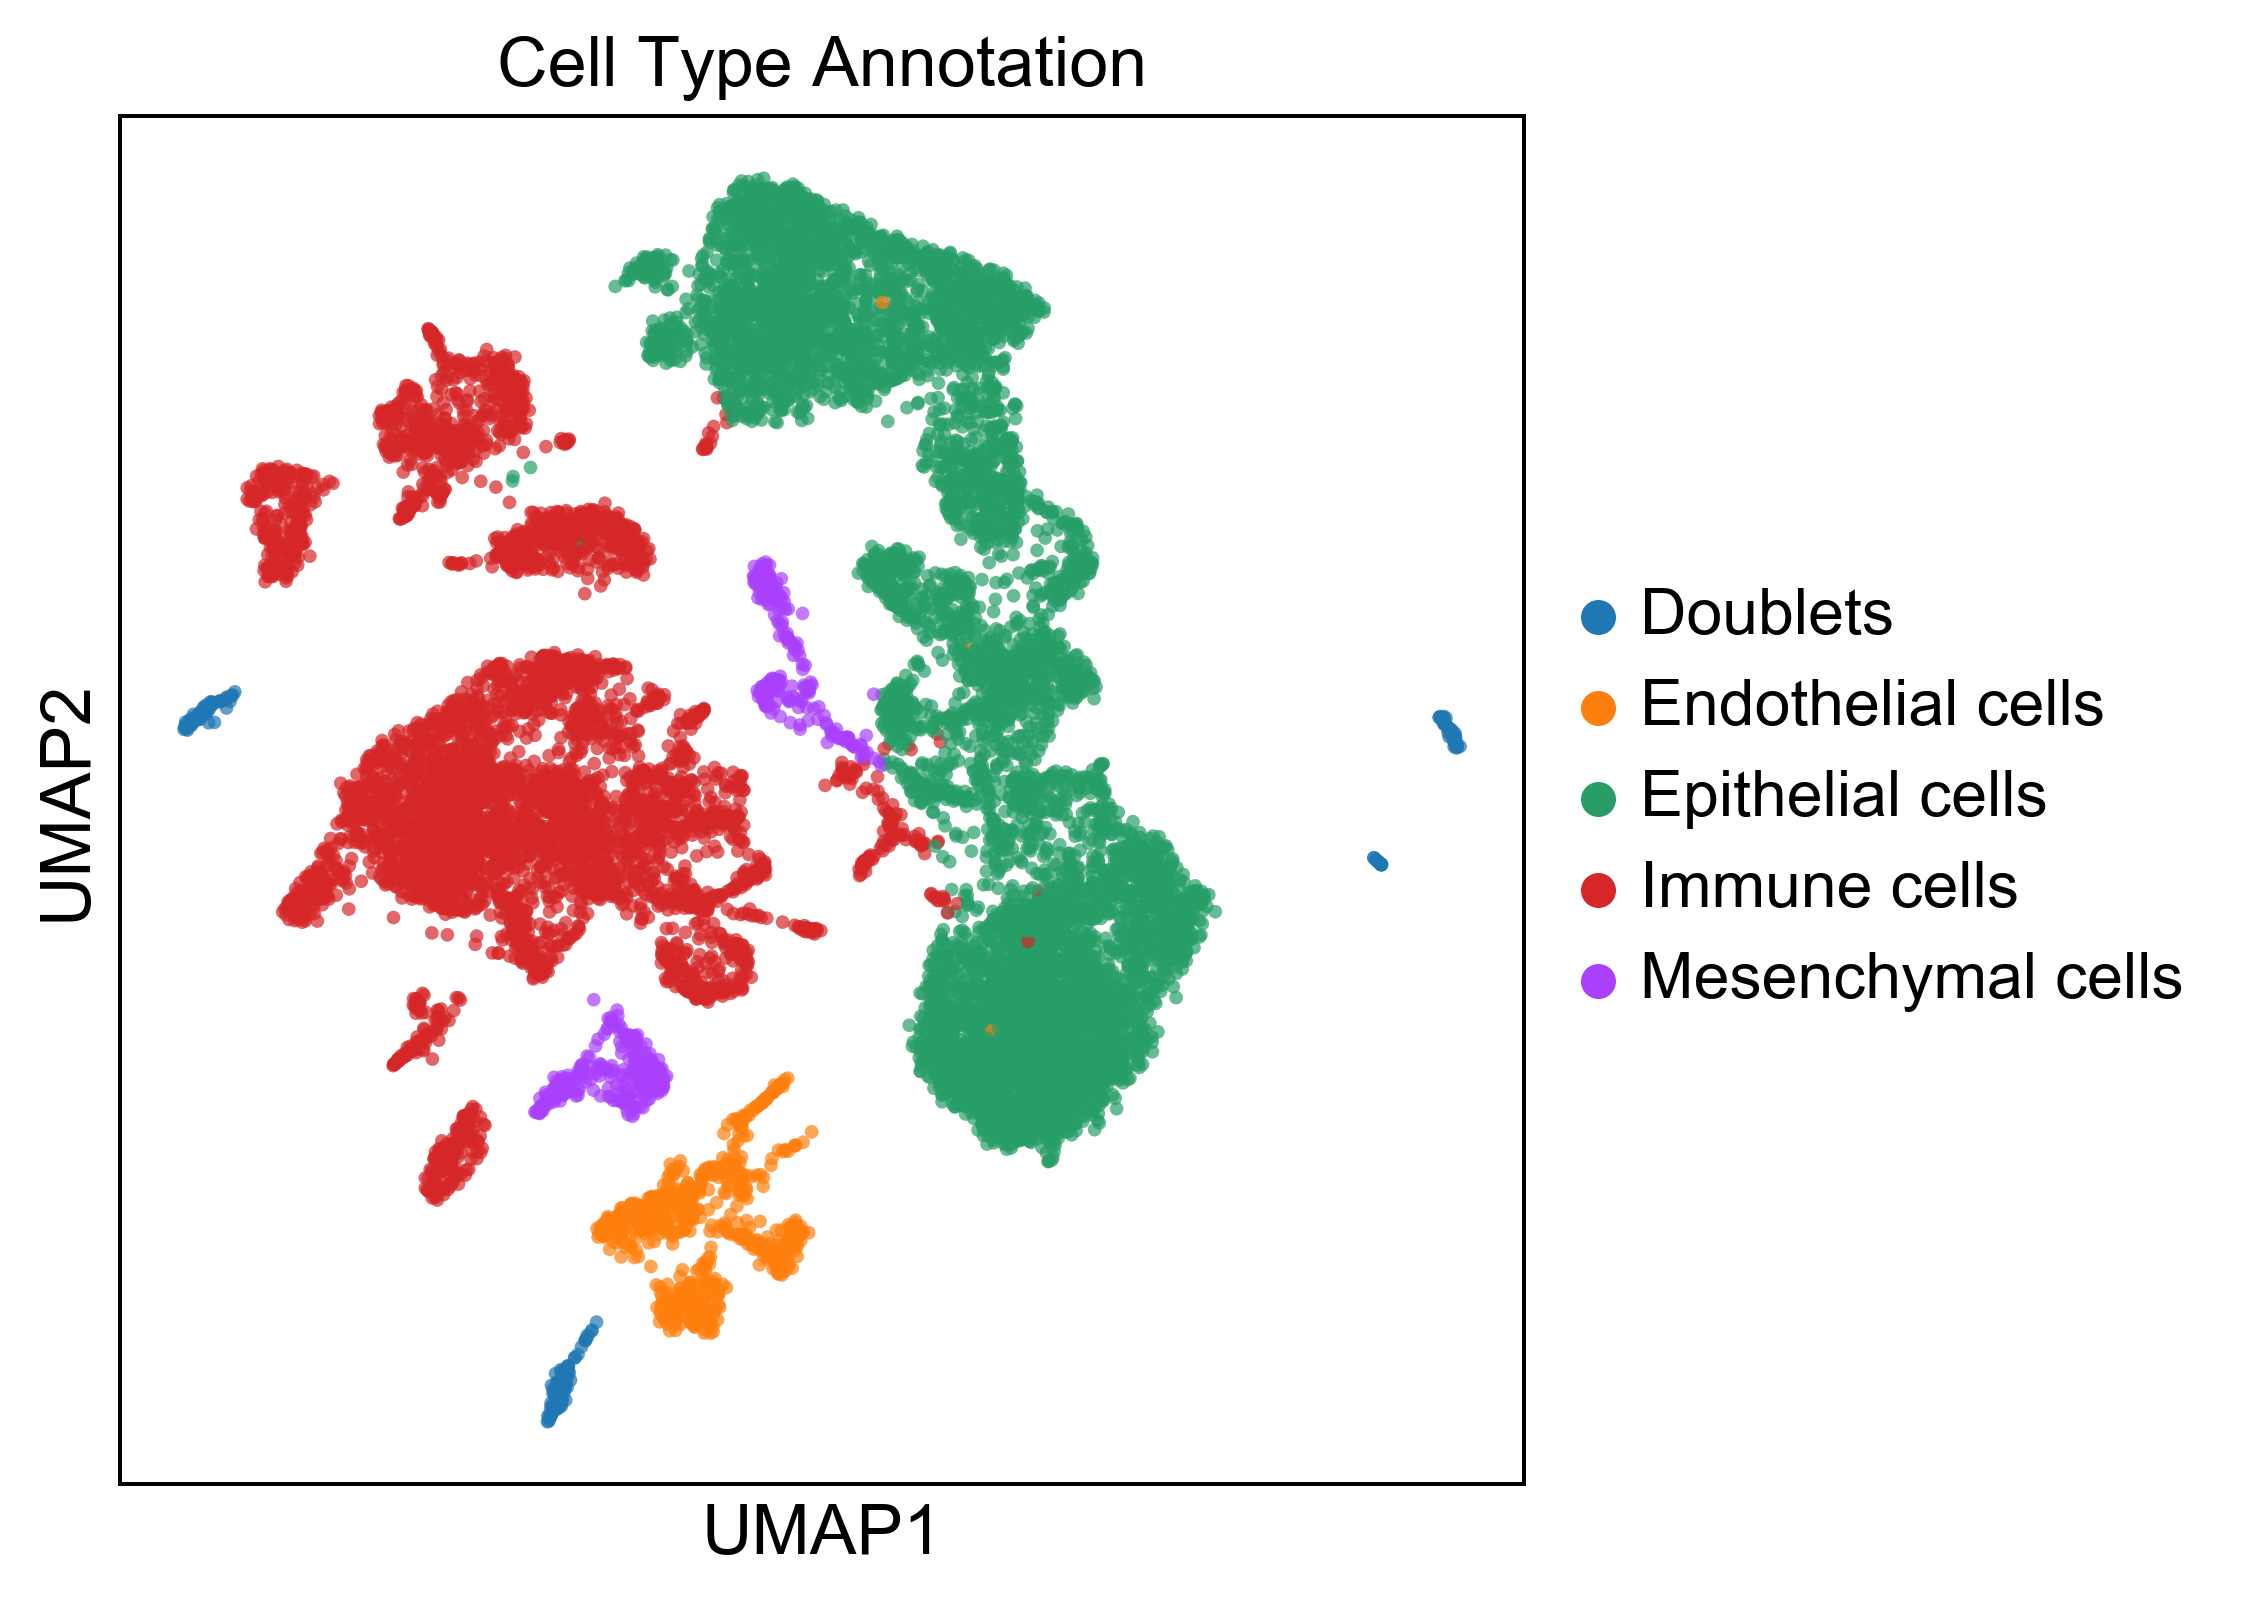

In [59]:
sc.pl.umap(adata, color='leiden_adata_clusters', legend_loc='right margin',title='Cell Type Annotation', frameon = True, s= 30,
           alpha = 0.7, ncols = 2, save = "_cell_annotation.pdf")

#legend_loc='on data'

In [60]:
adata.write(results_file)

# Subsetting cells 

In [61]:
adata = sc.read('../output/bleo.h5ad')

In [ ]:
#adata.obs['leiden_adata_clusters'].cat.categories

In [62]:
epi = adata[adata.obs['leiden_adata_clusters'].isin(['Epithelial cells'])]
epi.write('../data/epi.h5ad')
immune= adata[adata.obs['leiden_adata_clusters'].isin(['Immune cells'])]
immune.write('../data/immune.h5ad')
endo= adata[adata.obs['leiden_adata_clusters'].isin(['Endothelial cells'])]
endo.write('../data/endo.h5ad')
mesenchyme= adata[adata.obs['leiden_adata_clusters'].isin(['Mesenchymal cells'])]
mesenchyme.write('../data/mesenchyme.h5ad')

In [63]:
print(epi)
print(immune)
print(endo)
print(mesenchyme)

AnnData object with n_obs × n_vars = 7699 × 19924 
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden_r1.0', 'louvain_r1.0', 'leiden_adata_clusters'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_counts'
    uns: 'batch_colors', 'leiden', 'leiden_adata_clusters_colors', 'leiden_r1.0_colors', 'louvain', 'louvain_r1.0_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
AnnData object with n_obs × n_vars = 5244 × 19924 
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden_r1.0', 'louvain_r1.0', 'leiden_adata_clusters'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_counts'
    uns: 'batch_colors', 'leiden', 'leiden_adata_clusters_colors', 'leiden_r1.0_colors', 'louvain', 'louvain_r1.0_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
AnnData object with n_obs × n_vars = 693 × 19924 
    obs: 'batch', 'n_gen